**Imports**

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
!pip install pytorch_tabular
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, accuracy_score, confusion_matrix
from fastai.tabular.all import *
import seaborn as sns
!pip install optuna
import optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 30.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.2 MB/s eta 0:00:00


**Subject-Based Classifier**

In [18]:
def classify_grade_base(score, max_score=50, interval=15):
    excellent_threshold = max_score * 0.85  # 42.5
    good_threshold = max_score * 0.7        # 35
    medium_threshold = max_score * 0.55     # 27.5
    sufficient_threshold = max_score * 0.4  # 20

    if score > excellent_threshold:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold:
        return "MEDIUM"
    elif sufficient_threshold < score <= medium_threshold:
        return "SUFFICIENT"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade_base(score) for score in test_scores}
#print(results)

**Performance-Tiered Classifier**

In [2]:
def classify_grade(score, max_score=50):
    high_threshold = max_score * 0.6  # Top 60% and above
    medium_threshold = max_score * 0.4  # Middle 30-60%

    if score >= high_threshold:
        return "HIGH"
    elif score >= medium_threshold:
        return "MEDIUM"
    else:
        return "LOW"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Buffer-Zone Classifier**

In [17]:
def classify_grade(score, max_score=50, interval=15, buffer=0.06):
    # Define grade thresholds
    excellent_threshold = max_score * 0.85
    good_threshold = max_score * 0.7
    medium_threshold = max_score * 0.55
    sufficient_threshold = max_score * 0.4

    buffer_zone = max_score * buffer

    # Apply grading logic with buffer zones
    if score > excellent_threshold or (excellent_threshold - buffer_zone) <= score:
        return "EXCELLENT"
    elif good_threshold < score <= excellent_threshold or (good_threshold - buffer_zone) <= score < excellent_threshold:
        return "GOOD"
    elif medium_threshold < score <= good_threshold or (medium_threshold - buffer_zone) <= score < good_threshold:
        return "MEDIUM"
    elif sufficient_threshold < score <= medium_threshold or (sufficient_threshold - buffer_zone) <= score < medium_threshold:
        return "SUFFICIENT"
    else:
        return "FAIL"

#test_scores = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50]
#results = {score: classify_grade(score) for score in test_scores}
#print(results)

**Dataset without groups and times**

In [5]:
file_path = "./dataset_without_groups_and_time.xlsx"
grade_interval = 15
data_first_to_five = pd.read_excel(file_path)
data_first_to_five.rename(columns={'Id': 'id', 'AnonymId': 'anonym_id', '1. röpZH': 'first_zh', '2. röpZH': 'second_zh', '3. röpZH': 'third_zh','4. röpZH': 'fourth_zh','5. röpZH': 'fifth_zh','6. röpZH': 'sixth_zh','7. röpZH': 'seventh_zh','8. röpZH': 'eight_zh', '9. röpZH': 'ninth_zh', '10. röpZH': 'tenth_zh', '+1 (javító) röpZH': 'replace_exam', 'Beadandó': 'assignment'}, inplace=True)

data_first_to_six = pd.read_excel(file_path)
data_first_to_six.rename(columns={'Id': 'id', 'AnonymId': 'anonym_id', '1. röpZH': 'first_zh', '2. röpZH': 'second_zh', '3. röpZH': 'third_zh','4. röpZH': 'fourth_zh','5. röpZH': 'fifth_zh','6. röpZH': 'sixth_zh','7. röpZH': 'seventh_zh','8. röpZH': 'eight_zh', '9. röpZH': 'ninth_zh', '10. röpZH': 'tenth_zh', '+1 (javító) röpZH': 'replace_exam', 'Beadandó': 'assignment'}, inplace=True)

#XFive = data_first_to_five.drop(columns=['ZH', 'replace_exam', 'anonym_id', 'sixth_zh','seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
#YFive = data_first_to_five['ZH']

#XSix = data_first_to_six.drop(columns=['ZH', 'replace_exam', 'anonym_id', 'seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
#YSix = data_first_to_six['ZH']

XFive = data_first_to_five.drop(columns=['ZH', 'id', 'replace_exam', 'anonym_id', 'sixth_zh','seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
YFive = data_first_to_five['ZH']

XSix = data_first_to_six.drop(columns=['ZH', 'id' ,'replace_exam', 'anonym_id', 'seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
YSix = data_first_to_six['ZH']

XFive_train, XFive_test, YFive_train, YFive_test = train_test_split(XFive, YFive, test_size=0.2, random_state=42)
XSix_train, XSix_test, YSix_train, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)

scaler_five = StandardScaler()
XFive_train_scaled = scaler_five.fit_transform(XFive_train)
XFive_test_scaled = scaler_five.transform(XFive_test)

scaler_six = StandardScaler()
XSix_train_scaled = scaler_six.fit_transform(XSix_train)
XSix_test_scaled = scaler_six.transform(XSix_test)

**Dataset with groups and times**

In [4]:
file_path = "./dataset_with_groups_and_time.xlsx"
grade_interval = 15
data_first_to_five = pd.read_excel(file_path)
data_first_to_five.rename(columns={'Id': 'id', 'AnonymId': 'anonym_id', 'Csoport': 'group', 'Nap': 'day', 'Óra': 'start_hour', '1. röpZH': 'first_zh', '2. röpZH': 'second_zh', '3. röpZH': 'third_zh','4. röpZH': 'fourth_zh','5. röpZH': 'fifth_zh','6. röpZH': 'sixth_zh','7. röpZH': 'seventh_zh','8. röpZH': 'eight_zh', '9. röpZH': 'ninth_zh', '10. röpZH': 'tenth_zh', '+1 (javító) röpZH': 'replace_exam', 'Beadandó': 'assignment'}, inplace=True)

data_first_to_six = pd.read_excel(file_path)
data_first_to_six.rename(columns={'Id': 'id', 'AnonymId': 'anonym_id', 'Csoport': 'group', 'Nap': 'day', 'Óra': 'start_hour', '1. röpZH': 'first_zh', '2. röpZH': 'second_zh', '3. röpZH': 'third_zh','4. röpZH': 'fourth_zh','5. röpZH': 'fifth_zh','6. röpZH': 'sixth_zh','7. röpZH': 'seventh_zh','8. röpZH': 'eight_zh', '9. röpZH': 'ninth_zh', '10. röpZH': 'tenth_zh', '+1 (javító) röpZH': 'replace_exam', 'Beadandó': 'assignment'}, inplace=True)

#XFive = data_first_to_five.drop(columns=['ZH', 'replace_exam', 'anonym_id', 'sixth_zh','seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
#YFive = data_first_to_five['ZH']

#XSix = data_first_to_six.drop(columns=['ZH', 'replace_exam', 'anonym_id', 'seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
#YSix = data_first_to_six['ZH']

XFive = data_first_to_five.drop(columns=['ZH', 'id', 'replace_exam', 'anonym_id', 'sixth_zh','seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
YFive = data_first_to_five['ZH']

XSix = data_first_to_six.drop(columns=['ZH', 'id', 'replace_exam', 'anonym_id', 'seventh_zh','eight_zh','ninth_zh', 'tenth_zh'])
YSix = data_first_to_six['ZH']

XFive_train, XFive_test, YFive_train, YFive_test = train_test_split(XFive, YFive, test_size=0.2, random_state=42)
XSix_train, XSix_test, YSix_train, YSix_test = train_test_split(XSix, YSix, test_size=0.2, random_state=42)

scaler_five = StandardScaler()
XFive_train_scaled = scaler_five.fit_transform(XFive_train)
XFive_test_scaled = scaler_five.transform(XFive_test)

scaler_six = StandardScaler()
XSix_train_scaled = scaler_six.fit_transform(XSix_train)
XSix_test_scaled = scaler_six.transform(XSix_test)

**Metrics calculation**

In [20]:
def calculate_metrics(y_test, y_pred):
    test_grades = y_test.apply(lambda x: classify_grade(x))
    actual_grades = pd.Series(y_pred).apply(lambda x: classify_grade_base(x))
    metrics = {
        "MSE": mean_squared_error(y_test, y_pred),
        "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
        "MAE": mean_absolute_error(y_test, y_pred),
        "R2": r2_score(y_test, y_pred),
        "Accuracy": accuracy_score(test_grades,actual_grades)
    }
    return metrics

**Plot generation**

In [21]:
def generate_metrics_comparison(rf_five_values, rf_six_values, title):
    metrics = ['MSE', 'RMSE', 'MAE', 'R²']
    x = np.arange(len(metrics))
    width = 0.35
    fig, ax = plt.subplots(figsize=(10, 6))
    bars1 = ax.bar(x - width/2, rf_five_values, width, label='Model (5 weekly exams)', color='blue')
    bars2 = ax.bar(x + width/2, rf_six_values, width, label='Model (6 weekly exams)', color='orange')

    ax.set_xlabel('Metrics')
    ax.set_ylabel('Values')
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(metrics)
    ax.legend()

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{height:.2f}',
                        xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3),
                        textcoords="offset points",
                        ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

def generate_confusion_matrices(y_pred_five, y_pred_six):
    YFive_test_grades = YFive_test.apply(lambda x: classify_grade(x))
    YSix_test_grades = YSix_test.apply(lambda x: classify_grade(x))
    y_pred_five_grades = pd.Series(y_pred_five).apply(lambda x: classify_grade_base(x))
    y_pred_six_grades = pd.Series(y_pred_six).apply(lambda x: classify_grade_base(x))

    confusion_five = confusion_matrix(YFive_test_grades, y_pred_five_grades, labels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'])
    confusion_six = confusion_matrix(YSix_test_grades, y_pred_six_grades, labels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.heatmap(confusion_five, annot=True, fmt='d', cmap='Blues',
                xticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'],
                yticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'], ax=axes[0])
    axes[0].set_title("Model (5 weekly exams)")
    axes[0].set_xlabel("Predicted Grade")
    axes[0].set_ylabel("Actual Grade")

    sns.heatmap(confusion_six, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'],
                yticklabels=['FAIL', 'SUFFICIENT', 'MEDIUM', 'GOOD', 'EXCELLENT'], ax=axes[1])
    axes[1].set_title("Model (6 weekly exams)")
    axes[1].set_xlabel("Predicted Grade")
    axes[1].set_ylabel("Actual Grade")

    plt.tight_layout()
    plt.show()


"""def generate_confusion_matrices(y_pred_five, y_pred_six):
    YFive_test_grades = YFive_test.apply(lambda x: classify_grade(x))
    YSix_test_grades = YSix_test.apply(lambda x: classify_grade(x))
    y_pred_five_grades = pd.Series(y_pred_five).apply(lambda x: classify_grade(x))
    y_pred_six_grades = pd.Series(y_pred_six).apply(lambda x: classify_grade(x))

    confusion_five = confusion_matrix(YFive_test_grades, y_pred_five_grades, labels=['LOW', 'MEDIUM', 'HIGH'])
    confusion_six = confusion_matrix(YSix_test_grades, y_pred_six_grades, labels=['LOW', 'MEDIUM', 'HIGH'])

    fig, axes = plt.subplots(1, 2, figsize=(16, 8))

    sns.heatmap(confusion_five, annot=True, fmt='d', cmap='Blues',
                xticklabels=['LOW', 'MEDIUM', 'HIGH'],
                yticklabels=['LOW', 'MEDIUM', 'HIGH'], ax=axes[0])
    axes[0].set_title("Model (5 weekly exams)")
    axes[0].set_xlabel("Predicted Grade")
    axes[0].set_ylabel("Actual Grade")

    sns.heatmap(confusion_six, annot=True, fmt='d', cmap='Oranges',
                xticklabels=['LOW', 'MEDIUM', 'HIGH'],
                yticklabels=['LOW', 'MEDIUM', 'HIGH'], ax=axes[1])
    axes[1].set_title("Model (6 weekly exams)")
    axes[1].set_xlabel("Predicted Grade")
    axes[1].set_ylabel("Actual Grade")

    plt.tight_layout()
    plt.show()"""

def generate_predicted_vs_actual_comparison(YFive_test, y_pred_rf_five, YSix_test, y_pred_rf_six, title):
    plt.figure(figsize=(8, 6))
    plt.scatter(YFive_test, y_pred_rf_five, alpha=0.6, color='blue', label='Model (5 weekly exams)')
    plt.scatter(YSix_test, y_pred_rf_six, alpha=0.6, color='orange', label='Model (6 weekly exams)')
    plt.plot([min(YFive_test), max(YFive_test)], [min(YFive_test), max(YFive_test)], color='red', linestyle='--')
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.title(title)
    plt.legend()
    plt.tight_layout()
    plt.show()

def generate_accuracy_comparison(accuracy_five, accuracy_six, title):
    models = ['Model (5 weekly exams)', 'Model (6 weekly exams)']
    accuracies = [accuracy_five, accuracy_six]

    plt.figure(figsize=(8, 6))
    plt.bar(models, accuracies, color=['blue', 'orange'])
    plt.ylim(0, 1)
    plt.xlabel('Models')
    plt.ylabel('Accuracy')
    plt.title(title)

    for i, acc in enumerate(accuracies):
        plt.text(i, acc + 0.02, f"{acc:.2%}", ha='center', fontsize=12, color='black')

    plt.tight_layout()
    plt.show()

**TabnetRegressor Model**

In [8]:
tabnet_model_five = TabNetRegressor(
    n_d=48,
    n_a=48,
    n_steps=8,
    lambda_sparse=1e-5,
    momentum=0.6,
    gamma=1.8,
    mask_type="entmax"
)

X_train_five_scaled = XFive_train_scaled.astype(np.float32)
X_test_five_scaled = XFive_test_scaled.astype(np.float32)
y_five_train = YFive_train.values.astype(np.float32).reshape(-1, 1)
y_five_test = YFive_test.values.astype(np.float32).reshape(-1, 1)

tabnet_model_five.fit(
    X_train=X_train_five_scaled,
    y_train=y_five_train,
    eval_set=[(X_test_five_scaled, y_five_test)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=16
)

test_five_predictions = tabnet_model_five.predict(X_test_five_scaled)

tabnet_model_six = TabNetRegressor(
    n_d=48,
    n_a=48,
    n_steps=8,
    lambda_sparse=1e-5,
    momentum=0.6,
    gamma=1.8,
    mask_type="entmax"
)

X_train_six_scaled = XSix_train_scaled.astype(np.float32)
X_test_six_scaled = XSix_test_scaled.astype(np.float32)
y_six_train = YSix_train.values.astype(np.float32).reshape(-1, 1)
y_six_test = YSix_test.values.astype(np.float32).reshape(-1, 1)

tabnet_model_six.fit(
    X_train=X_train_six_scaled,
    y_train=y_six_train,
    eval_set=[(X_test_six_scaled, y_six_test)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=16
)

test_six_predictions = tabnet_model_six.predict(X_test_six_scaled)

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 418.0032| val_0_mse: 145.92148|  0:00:03s
epoch 1  | loss: 131.72766| val_0_mse: 143.39946|  0:00:05s
epoch 2  | loss: 115.12991| val_0_mse: 124.44923|  0:00:08s
epoch 3  | loss: 113.26008| val_0_mse: 121.49626|  0:00:10s
epoch 4  | loss: 106.44994| val_0_mse: 116.48917|  0:00:12s
epoch 5  | loss: 102.33988| val_0_mse: 108.8596|  0:00:14s
epoch 6  | loss: 103.27175| val_0_mse: 81.73788|  0:00:17s
epoch 7  | loss: 93.30281| val_0_mse: 88.45443|  0:00:19s
epoch 8  | loss: 93.6323 | val_0_mse: 107.95065|  0:00:21s
epoch 9  | loss: 95.3789 | val_0_mse: 103.57901|  0:00:23s
epoch 10 | loss: 103.07753| val_0_mse: 94.26162|  0:00:26s
epoch 11 | loss: 98.52752| val_0_mse: 102.89635|  0:00:28s
epoch 12 | loss: 91.0767 | val_0_mse: 87.24659|  0:00:30s
epoch 13 | loss: 96.49228| val_0_mse: 99.27533|  0:00:32s
epoch 14 | loss: 92.58532| val_0_mse: 85.85416|  0:00:35s
epoch 15 | loss: 91.58565| val_0_mse: 95.8047 |  0:00:37s
epoch 16 | loss: 92.60184| val_0_mse: 104.62519|  0:00:39

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 381.87472| val_0_mse: 146.35667|  0:00:02s
epoch 1  | loss: 114.87158| val_0_mse: 154.72969|  0:00:04s
epoch 2  | loss: 108.25428| val_0_mse: 165.99382|  0:00:06s
epoch 3  | loss: 119.10582| val_0_mse: 102.07042|  0:00:09s
epoch 4  | loss: 105.26001| val_0_mse: 81.27989|  0:00:11s
epoch 5  | loss: 99.95618| val_0_mse: 93.82301|  0:00:13s
epoch 6  | loss: 100.63504| val_0_mse: 97.79896|  0:00:15s
epoch 7  | loss: 96.55861| val_0_mse: 88.32961|  0:00:18s
epoch 8  | loss: 94.73682| val_0_mse: 78.24151|  0:00:20s
epoch 9  | loss: 95.01128| val_0_mse: 89.30241|  0:00:22s
epoch 10 | loss: 98.23881| val_0_mse: 88.22572|  0:00:24s
epoch 11 | loss: 86.36017| val_0_mse: 88.19582|  0:00:27s
epoch 12 | loss: 90.34623| val_0_mse: 74.65221|  0:00:29s
epoch 13 | loss: 94.43993| val_0_mse: 96.52595|  0:00:31s
epoch 14 | loss: 92.38573| val_0_mse: 96.65755|  0:00:33s
epoch 15 | loss: 93.36714| val_0_mse: 87.06885|  0:00:35s
epoch 16 | loss: 100.75909| val_0_mse: 105.38081|  0:00:38s
ep

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


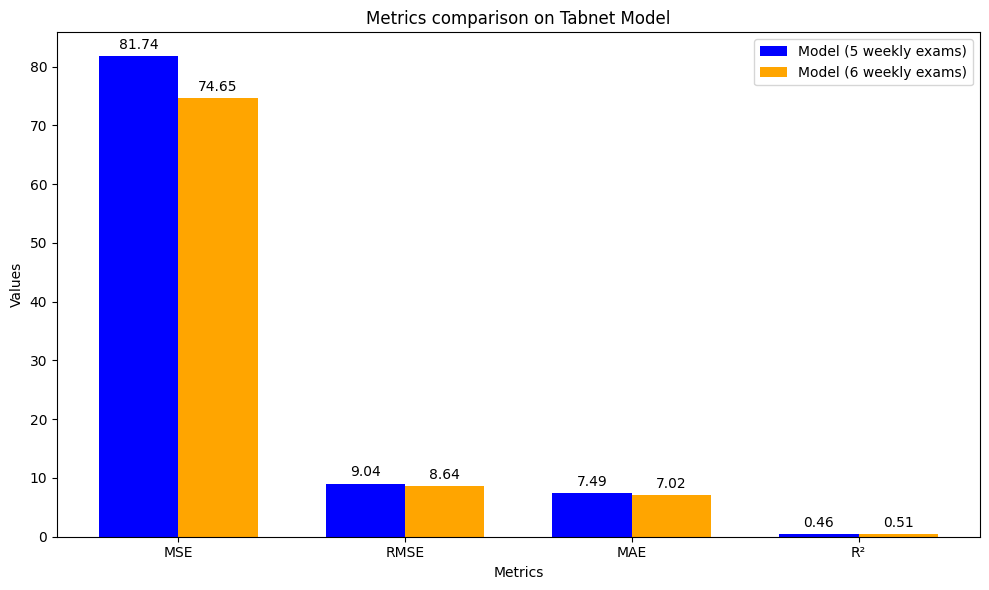

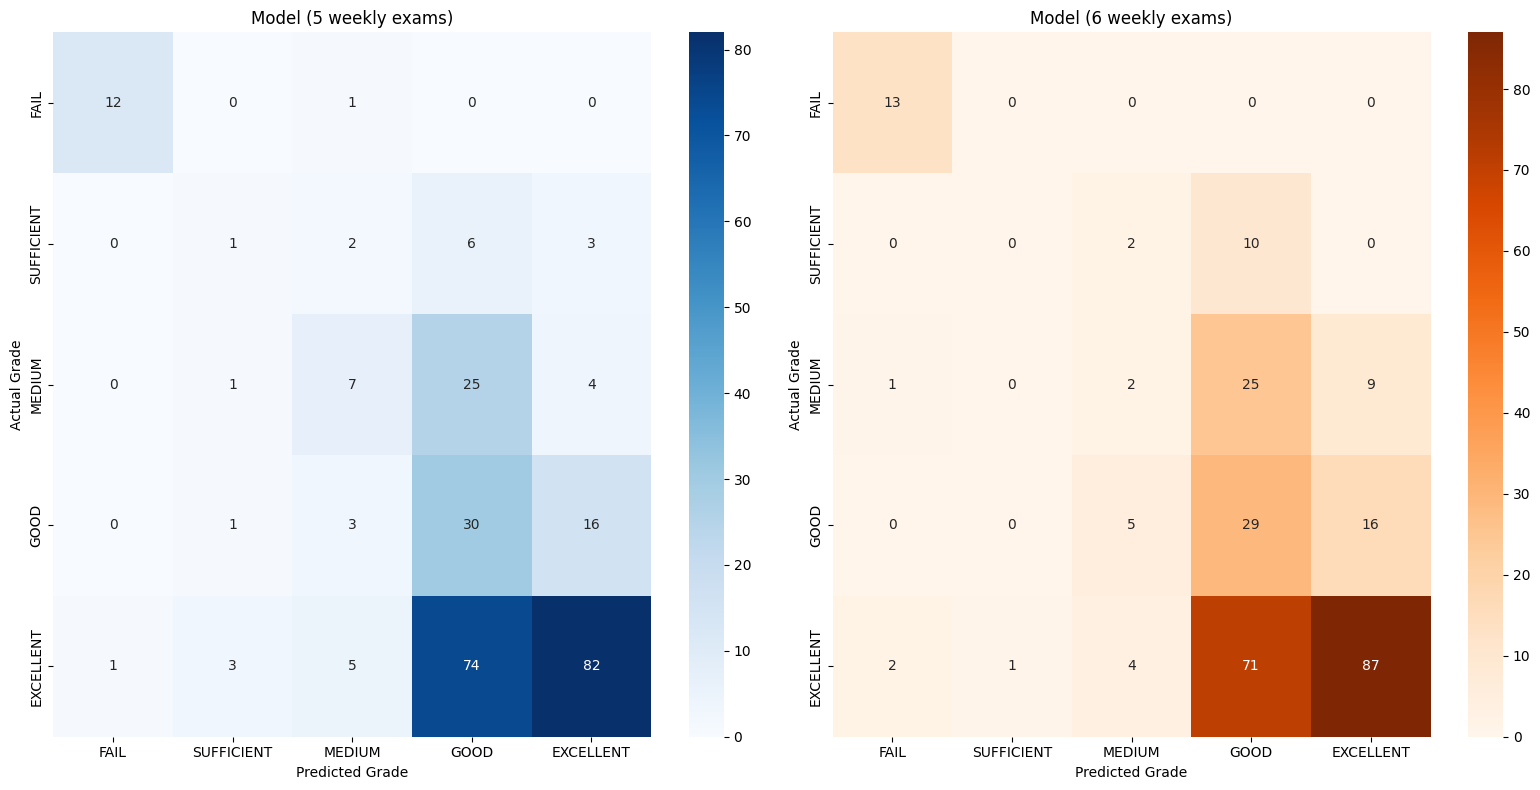

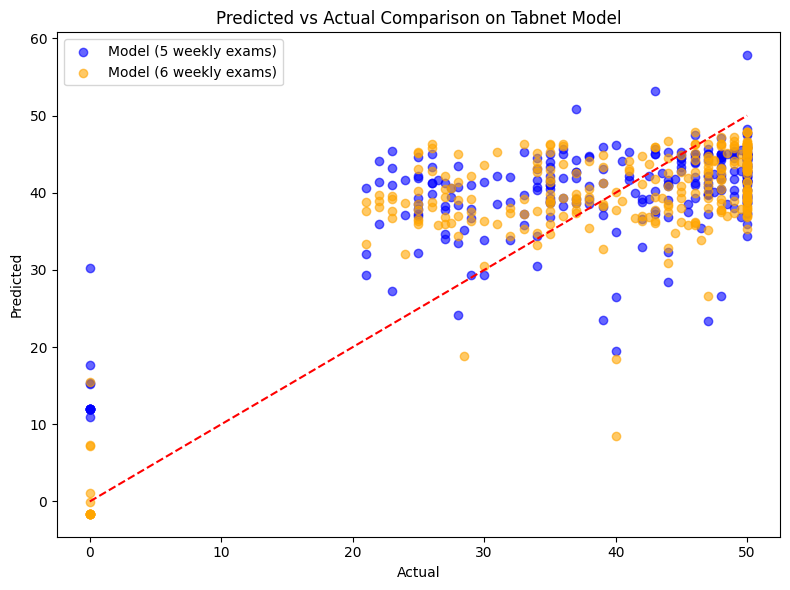

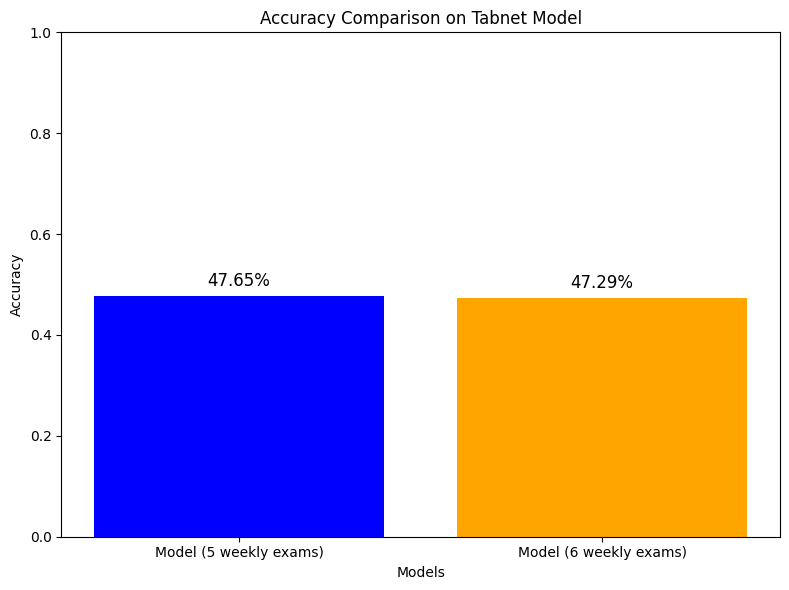

In [23]:
# Metrics calculation
tabnet_metrics_five = calculate_metrics(YFive_test, test_five_predictions.ravel())
tabnet_metrics_six = calculate_metrics(YSix_test, test_six_predictions.ravel())

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
tabnet_five_values = [tabnet_metrics_five["MSE"], tabnet_metrics_five["RMSE"], tabnet_metrics_five["MAE"], tabnet_metrics_five["R2"]]
tabnet_six_values = [tabnet_metrics_six["MSE"], tabnet_metrics_six["RMSE"], tabnet_metrics_six["MAE"], tabnet_metrics_six["R2"]]

# Plots
generate_metrics_comparison(tabnet_five_values, tabnet_six_values,"Metrics comparison on Tabnet Model")
generate_confusion_matrices(test_five_predictions.ravel(), test_six_predictions.ravel())
generate_predicted_vs_actual_comparison(YFive_test, test_five_predictions.ravel(), YSix_test, test_six_predictions.ravel(), "Predicted vs Actual Comparison on Tabnet Model")
generate_accuracy_comparison(tabnet_metrics_five["Accuracy"], tabnet_metrics_six["Accuracy"], "Accuracy Comparison on Tabnet Model")

**TabNetRegressor with best parameters**

In [10]:
def objective_five(trial):
    n_d = trial.suggest_int("n_d", 16, 64)
    n_a = trial.suggest_int("n_a", 16, 64)
    n_steps = trial.suggest_int("n_steps", 5, 10)
    lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
    momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
    gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.3)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        gamma=gamma,
        mask_type=mask_type
    )

    model.fit(
        X_train_five_scaled, y_five_train,
        eval_set=[(X_test_five_scaled, y_five_test)],
        max_epochs=50,
        patience=10,
        batch_size=32,
        virtual_batch_size=32,
        drop_last=False,
        from_unsupervised=None
    )

    predictions = model.predict(X_test_five_scaled)
    mse = mean_squared_error(y_five_test, predictions)

    return mse

def objective_six(trial):
    n_d = trial.suggest_int("n_d", 16, 64)
    n_a = trial.suggest_int("n_a", 16, 64)
    n_steps = trial.suggest_int("n_steps", 5, 10)
    lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
    momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
    gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
    mask_type = trial.suggest_categorical("mask_type", ["sparsemax", "entmax"])
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-3, 1e-1)
    dropout = trial.suggest_uniform("dropout", 0.0, 0.3)

    model = TabNetRegressor(
        n_d=n_d,
        n_a=n_a,
        n_steps=n_steps,
        lambda_sparse=lambda_sparse,
        momentum=momentum,
        gamma=gamma,
        mask_type=mask_type
    )

    model.fit(
        X_train_six_scaled, y_six_train,
        eval_set=[(X_test_six_scaled, y_six_test)],
        max_epochs=50,
        patience=10,
        batch_size=32,
        virtual_batch_size=32,
        drop_last=False,
        from_unsupervised=None
    )

    predictions = model.predict(X_test_six_scaled)
    mse = mean_squared_error(y_six_test, predictions)

    return mse

study_five = optuna.create_study(direction="minimize")
study_five.optimize(objective_five, n_trials=15)

study_six = optuna.create_study(direction="minimize")
study_six.optimize(objective_six, n_trials=15)

print("Best Hyperparameters model with 5 weekly exam:", study_five.best_params)
print("Best Hyperparameters model with 6 weekly exam:", study_six.best_params)

best_params_five = study_five.best_params
tabnet_best_five = TabNetRegressor(
    n_d=best_params_five["n_d"],
    n_a=best_params_five["n_a"],
    n_steps=best_params_five["n_steps"],
    lambda_sparse=best_params_five["lambda_sparse"],
    momentum=best_params_five["momentum"],
    gamma=best_params_five["gamma"],
    mask_type=best_params_five["mask_type"]
)

best_params_six = study_six.best_params
tabnet_best_six = TabNetRegressor(
    n_d=best_params_six["n_d"],
    n_a=best_params_six["n_a"],
    n_steps=best_params_six["n_steps"],
    lambda_sparse=best_params_six["lambda_sparse"],
    momentum=best_params_six["momentum"],
    gamma=best_params_six["gamma"],
    mask_type=best_params_six["mask_type"]
)

tabnet_best_five.fit(
    X_train_five_scaled, y_five_train,
    eval_set=[(X_test_five_scaled, y_five_test)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=32,
    drop_last=False,
    from_unsupervised=None
)

tabnet_best_six.fit(
    X_train_six_scaled, y_six_train,
    eval_set=[(X_test_six_scaled, y_six_test)],
    max_epochs=100,
    patience=15,
    batch_size=32,
    virtual_batch_size=32,
    drop_last=False,
    from_unsupervised=None
)

final_predictions_five = tabnet_best_five.predict(X_test_five_scaled)
final_predictions_six = tabnet_best_six.predict(X_test_six_scaled)

#torch.save(tabnet_best_six, "tabnet_best_six.pth")

[I 2025-03-15 15:01:10,339] A new study created in memory with name: no-name-ce182abd-dec5-4360-9ea2-9f73d09a8d85
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  momentum = trial.suggest_uniform("momentum", 0.3, 0.7)
<ipython-input-10-2cb472c8ec0f>:7: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  gamma = trial.suggest_uniform("gamma", 1.0, 2.0)
<ipython-input-10-2cb4

epoch 0  | loss: 394.35873| val_0_mse: 105.31137|  0:00:02s
epoch 1  | loss: 113.00074| val_0_mse: 116.65932|  0:00:04s
epoch 2  | loss: 111.50992| val_0_mse: 89.23415|  0:00:06s
epoch 3  | loss: 96.28281| val_0_mse: 88.82091|  0:00:08s
epoch 4  | loss: 92.30202| val_0_mse: 95.21677|  0:00:10s
epoch 5  | loss: 93.54   | val_0_mse: 90.77845|  0:00:12s
epoch 6  | loss: 91.09842| val_0_mse: 89.44547|  0:00:14s
epoch 7  | loss: 89.11209| val_0_mse: 87.25252|  0:00:16s
epoch 8  | loss: 89.36161| val_0_mse: 82.63944|  0:00:19s
epoch 9  | loss: 91.12056| val_0_mse: 82.51204|  0:00:21s
epoch 10 | loss: 88.22818| val_0_mse: 94.09017|  0:00:23s
epoch 11 | loss: 88.54055| val_0_mse: 98.29338|  0:00:25s
epoch 12 | loss: 90.90945| val_0_mse: 84.63017|  0:00:27s
epoch 13 | loss: 85.04869| val_0_mse: 83.22405|  0:00:29s
epoch 14 | loss: 86.85377| val_0_mse: 83.15921|  0:00:31s
epoch 15 | loss: 90.54823| val_0_mse: 84.2253 |  0:00:33s
epoch 16 | loss: 87.18973| val_0_mse: 81.774  |  0:00:35s
epoch 17 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:02:37,790] Trial 0 finished with value: 76.62926483154297 and parameters: {'n_d': 33, 'n_a': 52, 'n_steps': 8, 'lambda_sparse': 4.3412419808513084e-05, 'momentum': 0.627120954604142, 'gamma': 1.826289258234388, 'mask_type': 'entmax', 'learning_rate': 0.012641886960215114, 'dropout': 0.23863314001022293}. Best is trial 0 with value: 76.62926483154297.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

epoch 0  | loss: 293.74111| val_0_mse: 115.00133|  0:00:01s
epoch 1  | loss: 130.82435| val_0_mse: 116.13991|  0:00:02s
epoch 2  | loss: 108.85484| val_0_mse: 95.35867|  0:00:04s
epoch 3  | loss: 94.5729 | val_0_mse: 88.69155|  0:00:05s
epoch 4  | loss: 101.95383| val_0_mse: 93.27578|  0:00:07s
epoch 5  | loss: 99.54899| val_0_mse: 115.5518|  0:00:08s
epoch 6  | loss: 104.02458| val_0_mse: 85.70009|  0:00:09s
epoch 7  | loss: 93.9494 | val_0_mse: 95.25041|  0:00:11s
epoch 8  | loss: 98.19528| val_0_mse: 94.96246|  0:00:12s
epoch 9  | loss: 92.8324 | val_0_mse: 90.32342|  0:00:14s
epoch 10 | loss: 95.48577| val_0_mse: 94.71751|  0:00:15s
epoch 11 | loss: 90.44356| val_0_mse: 93.02586|  0:00:16s
epoch 12 | loss: 97.54825| val_0_mse: 90.08955|  0:00:18s
epoch 13 | loss: 92.61478| val_0_mse: 99.23897|  0:00:19s
epoch 14 | loss: 92.05159| val_0_mse: 88.30185|  0:00:21s
epoch 15 | loss: 94.11566| val_0_mse: 82.4058 |  0:00:22s
epoch 16 | loss: 88.54083| val_0_mse: 86.29539|  0:00:24s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:03:20,866] Trial 1 finished with value: 78.89500427246094 and parameters: {'n_d': 59, 'n_a': 56, 'n_steps': 5, 'lambda_sparse': 1.1169705616008947e-05, 'momentum': 0.5903268222825735, 'gamma': 1.658010890993845, 'mask_type': 'sparsemax', 'learning_rate': 0.008544867880926725, 'dropout': 0.07344530570794157}. Best is trial 0 with value: 76.62926483154297.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

epoch 0  | loss: 364.51438| val_0_mse: 101.7023|  0:00:01s
epoch 1  | loss: 106.51153| val_0_mse: 90.95317|  0:00:03s
epoch 2  | loss: 95.24689| val_0_mse: 95.82074|  0:00:04s
epoch 3  | loss: 101.81972| val_0_mse: 83.47603|  0:00:06s
epoch 4  | loss: 92.39111| val_0_mse: 88.87817|  0:00:08s
epoch 5  | loss: 88.11098| val_0_mse: 86.62025|  0:00:09s
epoch 6  | loss: 89.31376| val_0_mse: 83.11441|  0:00:11s
epoch 7  | loss: 83.83921| val_0_mse: 90.03404|  0:00:13s
epoch 8  | loss: 88.25539| val_0_mse: 88.64622|  0:00:14s
epoch 9  | loss: 85.75552| val_0_mse: 83.55602|  0:00:16s
epoch 10 | loss: 83.93199| val_0_mse: 81.85588|  0:00:18s
epoch 11 | loss: 89.33031| val_0_mse: 93.09117|  0:00:19s
epoch 12 | loss: 89.45645| val_0_mse: 83.25278|  0:00:21s
epoch 13 | loss: 87.3282 | val_0_mse: 88.57232|  0:00:23s
epoch 14 | loss: 82.93629| val_0_mse: 84.62478|  0:00:24s
epoch 15 | loss: 81.95141| val_0_mse: 90.47448|  0:00:26s
epoch 16 | loss: 88.08724| val_0_mse: 81.77563|  0:00:27s
epoch 17 | 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:04:24,406] Trial 2 finished with value: 76.64704132080078 and parameters: {'n_d': 28, 'n_a': 48, 'n_steps': 6, 'lambda_sparse': 6.585475114999662e-05, 'momentum': 0.38204746901276176, 'gamma': 1.4774371663401071, 'mask_type': 'entmax', 'learning_rate': 0.0058057714310680445, 'dropout': 0.1429804531271866}. Best is trial 0 with value: 76.62926483154297.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 469.24673| val_0_mse: 107.50138|  0:00:02s
epoch 1  | loss: 101.32474| val_0_mse: 100.93958|  0:00:04s
epoch 2  | loss: 97.21201| val_0_mse: 97.29818|  0:00:07s
epoch 3  | loss: 103.65071| val_0_mse: 93.71508|  0:00:09s
epoch 4  | loss: 88.91682| val_0_mse: 80.74928|  0:00:11s
epoch 5  | loss: 89.75274| val_0_mse: 94.38918|  0:00:14s
epoch 6  | loss: 89.50494| val_0_mse: 86.49125|  0:00:16s
epoch 7  | loss: 85.0246 | val_0_mse: 79.65344|  0:00:18s
epoch 8  | loss: 84.6115 | val_0_mse: 83.15193|  0:00:21s
epoch 9  | loss: 86.18915| val_0_mse: 91.78696|  0:00:23s
epoch 10 | loss: 86.26186| val_0_mse: 85.77098|  0:00:25s
epoch 11 | loss: 81.12062| val_0_mse: 83.04214|  0:00:28s
epoch 12 | loss: 87.35737| val_0_mse: 87.42276|  0:00:30s
epoch 13 | loss: 86.83159| val_0_mse: 85.85107|  0:00:32s
epoch 14 | loss: 80.90263| val_0_mse: 85.27292|  0:00:35s
epoch 15 | loss: 83.67542| val_0_mse: 83.05191|  0:00:37s
epoch 16 | loss: 82.30822| val_0_mse: 83.99739|  0:00:39s
epoch 17 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:05:07,992] Trial 3 finished with value: 79.6534423828125 and parameters: {'n_d': 24, 'n_a': 57, 'n_steps': 9, 'lambda_sparse': 3.3709299747125353e-05, 'momentum': 0.5801579722612564, 'gamma': 1.0782381563406065, 'mask_type': 'entmax', 'learning_rate': 0.09504729953785505, 'dropout': 0.15253497328502866}. Best is trial 0 with value: 76.62926483154297.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://githu

epoch 0  | loss: 594.42043| val_0_mse: 115.74812|  0:00:01s
epoch 1  | loss: 108.70936| val_0_mse: 93.46032|  0:00:02s
epoch 2  | loss: 100.04024| val_0_mse: 93.29092|  0:00:04s
epoch 3  | loss: 101.23828| val_0_mse: 97.14581|  0:00:05s
epoch 4  | loss: 95.33544| val_0_mse: 95.5886 |  0:00:07s
epoch 5  | loss: 98.6135 | val_0_mse: 100.26593|  0:00:08s
epoch 6  | loss: 94.1018 | val_0_mse: 89.92922|  0:00:09s
epoch 7  | loss: 93.91964| val_0_mse: 88.46157|  0:00:11s
epoch 8  | loss: 96.00241| val_0_mse: 91.10728|  0:00:12s
epoch 9  | loss: 86.13207| val_0_mse: 87.25893|  0:00:14s
epoch 10 | loss: 90.19566| val_0_mse: 82.46677|  0:00:15s
epoch 11 | loss: 84.28511| val_0_mse: 85.53979|  0:00:16s
epoch 12 | loss: 88.60502| val_0_mse: 86.43857|  0:00:18s
epoch 13 | loss: 86.95513| val_0_mse: 87.14233|  0:00:19s
epoch 14 | loss: 90.11337| val_0_mse: 89.04678|  0:00:21s
epoch 15 | loss: 85.6442 | val_0_mse: 81.37452|  0:00:22s
epoch 16 | loss: 87.23011| val_0_mse: 81.25016|  0:00:23s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:06:19,204] Trial 4 finished with value: 78.20043182373047 and parameters: {'n_d': 32, 'n_a': 17, 'n_steps': 5, 'lambda_sparse': 3.473153137705067e-05, 'momentum': 0.6350882819346215, 'gamma': 1.252187094167487, 'mask_type': 'sparsemax', 'learning_rate': 0.004089173605204092, 'dropout': 0.19303211498866904}. Best is trial 0 with value: 76.62926483154297.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 351.74211| val_0_mse: 141.74893|  0:00:02s
epoch 1  | loss: 102.93564| val_0_mse: 111.19982|  0:00:04s
epoch 2  | loss: 99.25297| val_0_mse: 99.16932|  0:00:06s
epoch 3  | loss: 96.07762| val_0_mse: 94.13532|  0:00:08s
epoch 4  | loss: 99.57648| val_0_mse: 85.15398|  0:00:10s
epoch 5  | loss: 95.36333| val_0_mse: 90.19097|  0:00:12s
epoch 6  | loss: 95.14284| val_0_mse: 80.44859|  0:00:14s
epoch 7  | loss: 85.46101| val_0_mse: 85.72221|  0:00:16s
epoch 8  | loss: 84.64425| val_0_mse: 80.70764|  0:00:19s
epoch 9  | loss: 85.29162| val_0_mse: 84.06036|  0:00:21s
epoch 10 | loss: 84.48552| val_0_mse: 80.56618|  0:00:23s
epoch 11 | loss: 86.89562| val_0_mse: 79.43461|  0:00:25s
epoch 12 | loss: 82.49908| val_0_mse: 81.5089 |  0:00:27s
epoch 13 | loss: 86.04005| val_0_mse: 92.03329|  0:00:29s
epoch 14 | loss: 86.22057| val_0_mse: 82.92535|  0:00:31s
epoch 15 | loss: 82.40253| val_0_mse: 81.50188|  0:00:33s
epoch 16 | loss: 86.78967| val_0_mse: 84.02316|  0:00:35s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:07:32,136] Trial 5 finished with value: 75.8631820678711 and parameters: {'n_d': 59, 'n_a': 36, 'n_steps': 8, 'lambda_sparse': 2.2121982664468504e-05, 'momentum': 0.5573919031153343, 'gamma': 1.0923714873249017, 'mask_type': 'entmax', 'learning_rate': 0.03391854734478699, 'dropout': 0.23955487978527695}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

epoch 0  | loss: 584.01045| val_0_mse: 127.62553|  0:00:02s
epoch 1  | loss: 113.24517| val_0_mse: 104.23637|  0:00:04s
epoch 2  | loss: 111.14402| val_0_mse: 102.35407|  0:00:06s
epoch 3  | loss: 103.14458| val_0_mse: 95.24206|  0:00:08s
epoch 4  | loss: 106.4234| val_0_mse: 93.49109|  0:00:10s
epoch 5  | loss: 108.44526| val_0_mse: 106.61603|  0:00:12s
epoch 6  | loss: 100.3351| val_0_mse: 94.57288|  0:00:14s
epoch 7  | loss: 100.02261| val_0_mse: 91.12211|  0:00:16s
epoch 8  | loss: 91.17279| val_0_mse: 98.30701|  0:00:18s
epoch 9  | loss: 92.21049| val_0_mse: 93.09921|  0:00:21s
epoch 10 | loss: 89.63789| val_0_mse: 118.38995|  0:00:23s
epoch 11 | loss: 92.79717| val_0_mse: 118.85808|  0:00:25s
epoch 12 | loss: 102.16999| val_0_mse: 98.19543|  0:00:27s
epoch 13 | loss: 98.27243| val_0_mse: 86.4449 |  0:00:29s
epoch 14 | loss: 101.87118| val_0_mse: 89.44138|  0:00:31s
epoch 15 | loss: 101.5983| val_0_mse: 93.68478|  0:00:33s
epoch 16 | loss: 89.43704| val_0_mse: 85.15491|  0:00:35s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:09:18,483] Trial 6 finished with value: 75.94694519042969 and parameters: {'n_d': 31, 'n_a': 39, 'n_steps': 8, 'lambda_sparse': 7.024170174558755e-05, 'momentum': 0.6926623233292374, 'gamma': 1.435925204788771, 'mask_type': 'sparsemax', 'learning_rate': 0.03646153970344031, 'dropout': 0.19274574436056766}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gith

epoch 0  | loss: 257.78221| val_0_mse: 118.97304|  0:00:02s
epoch 1  | loss: 119.01181| val_0_mse: 93.2252 |  0:00:05s
epoch 2  | loss: 97.54213| val_0_mse: 97.17743|  0:00:07s
epoch 3  | loss: 97.61044| val_0_mse: 108.48673|  0:00:10s
epoch 4  | loss: 96.40764| val_0_mse: 102.13128|  0:00:12s
epoch 5  | loss: 98.09999| val_0_mse: 104.16938|  0:00:15s
epoch 6  | loss: 92.74769| val_0_mse: 93.90566|  0:00:17s
epoch 7  | loss: 94.0586 | val_0_mse: 85.36463|  0:00:20s
epoch 8  | loss: 90.13572| val_0_mse: 81.12534|  0:00:22s
epoch 9  | loss: 84.59668| val_0_mse: 86.67657|  0:00:25s
epoch 10 | loss: 86.39385| val_0_mse: 85.04212|  0:00:28s
epoch 11 | loss: 87.07564| val_0_mse: 90.39453|  0:00:30s
epoch 12 | loss: 89.10279| val_0_mse: 92.6749 |  0:00:33s
epoch 13 | loss: 87.91095| val_0_mse: 81.90192|  0:00:35s
epoch 14 | loss: 86.49588| val_0_mse: 92.16119|  0:00:38s
epoch 15 | loss: 86.9371 | val_0_mse: 90.26427|  0:00:40s
epoch 16 | loss: 95.42104| val_0_mse: 99.1576 |  0:00:43s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:10:08,442] Trial 7 finished with value: 81.12533569335938 and parameters: {'n_d': 48, 'n_a': 27, 'n_steps': 10, 'lambda_sparse': 5.017906428856455e-05, 'momentum': 0.3688948709055634, 'gamma': 1.0642528811174081, 'mask_type': 'sparsemax', 'learning_rate': 0.02045192205251434, 'dropout': 0.2768289579683435}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 404.83164| val_0_mse: 102.99213|  0:00:02s
epoch 1  | loss: 109.7994| val_0_mse: 99.45874|  0:00:04s
epoch 2  | loss: 103.44931| val_0_mse: 91.70757|  0:00:06s
epoch 3  | loss: 98.9777 | val_0_mse: 88.87309|  0:00:08s
epoch 4  | loss: 92.81122| val_0_mse: 96.71149|  0:00:10s
epoch 5  | loss: 91.79449| val_0_mse: 92.64877|  0:00:13s
epoch 6  | loss: 92.09489| val_0_mse: 118.26725|  0:00:15s
epoch 7  | loss: 94.98006| val_0_mse: 103.18142|  0:00:17s
epoch 8  | loss: 92.07678| val_0_mse: 106.83971|  0:00:19s
epoch 9  | loss: 90.52394| val_0_mse: 83.57814|  0:00:21s
epoch 10 | loss: 83.19827| val_0_mse: 90.07026|  0:00:23s
epoch 11 | loss: 89.75354| val_0_mse: 82.02877|  0:00:26s
epoch 12 | loss: 82.93567| val_0_mse: 85.60196|  0:00:28s
epoch 13 | loss: 86.70015| val_0_mse: 85.52029|  0:00:30s
epoch 14 | loss: 84.5793 | val_0_mse: 89.7383 |  0:00:32s
epoch 15 | loss: 88.69596| val_0_mse: 100.36719|  0:00:34s
epoch 16 | loss: 86.80473| val_0_mse: 89.20771|  0:00:36s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:10:56,987] Trial 8 finished with value: 82.02877044677734 and parameters: {'n_d': 41, 'n_a': 38, 'n_steps': 8, 'lambda_sparse': 2.3845510750761945e-05, 'momentum': 0.5327016359061355, 'gamma': 1.5096163959135938, 'mask_type': 'entmax', 'learning_rate': 0.013099489235519044, 'dropout': 0.080620618617834}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github

epoch 0  | loss: 645.46905| val_0_mse: 123.91579|  0:00:01s
epoch 1  | loss: 112.92163| val_0_mse: 87.0071 |  0:00:02s
epoch 2  | loss: 95.15111| val_0_mse: 95.24155|  0:00:04s
epoch 3  | loss: 98.54504| val_0_mse: 109.45201|  0:00:05s
epoch 4  | loss: 96.3794 | val_0_mse: 94.98228|  0:00:07s
epoch 5  | loss: 97.3668 | val_0_mse: 84.29639|  0:00:08s
epoch 6  | loss: 90.22306| val_0_mse: 84.65474|  0:00:09s
epoch 7  | loss: 87.38285| val_0_mse: 93.25237|  0:00:11s
epoch 8  | loss: 92.59728| val_0_mse: 85.86606|  0:00:12s
epoch 9  | loss: 88.50137| val_0_mse: 83.77297|  0:00:14s
epoch 10 | loss: 87.88504| val_0_mse: 84.32476|  0:00:15s
epoch 11 | loss: 90.69701| val_0_mse: 93.14526|  0:00:17s
epoch 12 | loss: 88.85078| val_0_mse: 91.03933|  0:00:18s
epoch 13 | loss: 83.27978| val_0_mse: 92.16028|  0:00:19s
epoch 14 | loss: 84.10798| val_0_mse: 82.33607|  0:00:21s
epoch 15 | loss: 85.67001| val_0_mse: 81.82267|  0:00:22s
epoch 16 | loss: 85.6102 | val_0_mse: 80.82044|  0:00:24s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:11:40,678] Trial 9 finished with value: 78.03306579589844 and parameters: {'n_d': 21, 'n_a': 44, 'n_steps': 5, 'lambda_sparse': 2.8000745133824434e-05, 'momentum': 0.34266176463349507, 'gamma': 1.1332808278569475, 'mask_type': 'sparsemax', 'learning_rate': 0.005746803758456852, 'dropout': 0.19698922376926528}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 365.41943| val_0_mse: 113.74352|  0:00:01s
epoch 1  | loss: 108.35217| val_0_mse: 119.67786|  0:00:03s
epoch 2  | loss: 102.39392| val_0_mse: 106.75446|  0:00:05s
epoch 3  | loss: 97.45682| val_0_mse: 97.07912|  0:00:07s
epoch 4  | loss: 94.60811| val_0_mse: 93.50097|  0:00:09s
epoch 5  | loss: 94.59054| val_0_mse: 89.66233|  0:00:11s
epoch 6  | loss: 89.69339| val_0_mse: 89.3872 |  0:00:13s
epoch 7  | loss: 101.33104| val_0_mse: 87.44993|  0:00:15s
epoch 8  | loss: 89.59913| val_0_mse: 97.3176 |  0:00:17s
epoch 9  | loss: 93.85549| val_0_mse: 95.61155|  0:00:19s
epoch 10 | loss: 93.65067| val_0_mse: 83.56117|  0:00:21s
epoch 11 | loss: 90.59011| val_0_mse: 88.07452|  0:00:22s
epoch 12 | loss: 92.98044| val_0_mse: 89.09863|  0:00:24s
epoch 13 | loss: 87.99535| val_0_mse: 94.04216|  0:00:26s
epoch 14 | loss: 84.95343| val_0_mse: 85.1356 |  0:00:28s
epoch 15 | loss: 88.24061| val_0_mse: 85.1367 |  0:00:30s
epoch 16 | loss: 84.1195 | val_0_mse: 88.23312|  0:00:32s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:12:35,096] Trial 10 finished with value: 79.97828674316406 and parameters: {'n_d': 64, 'n_a': 30, 'n_steps': 7, 'lambda_sparse': 1.513358786652908e-05, 'momentum': 0.4603736185566468, 'gamma': 1.3004834682085062, 'mask_type': 'entmax', 'learning_rate': 0.0012952869825152821, 'dropout': 0.012780620229074197}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 287.87924| val_0_mse: 128.05782|  0:00:01s
epoch 1  | loss: 111.86137| val_0_mse: 96.32618|  0:00:03s
epoch 2  | loss: 107.64788| val_0_mse: 94.77216|  0:00:05s
epoch 3  | loss: 107.68311| val_0_mse: 122.35371|  0:00:07s
epoch 4  | loss: 108.29905| val_0_mse: 122.88281|  0:00:09s
epoch 5  | loss: 101.45499| val_0_mse: 106.86936|  0:00:11s
epoch 6  | loss: 109.72738| val_0_mse: 96.1813 |  0:00:13s
epoch 7  | loss: 100.3371| val_0_mse: 94.24591|  0:00:15s
epoch 8  | loss: 101.39688| val_0_mse: 89.34962|  0:00:17s
epoch 9  | loss: 91.70774| val_0_mse: 105.33388|  0:00:19s
epoch 10 | loss: 95.58548| val_0_mse: 83.33324|  0:00:21s
epoch 11 | loss: 94.51561| val_0_mse: 83.50864|  0:00:23s
epoch 12 | loss: 99.25275| val_0_mse: 85.29164|  0:00:24s
epoch 13 | loss: 89.29655| val_0_mse: 89.00334|  0:00:26s
epoch 14 | loss: 86.44374| val_0_mse: 79.46967|  0:00:28s
epoch 15 | loss: 87.71494| val_0_mse: 79.3512 |  0:00:30s
epoch 16 | loss: 87.40612| val_0_mse: 79.64278|  0:00:32s
e

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:13:31,497] Trial 11 finished with value: 76.99116516113281 and parameters: {'n_d': 50, 'n_a': 36, 'n_steps': 7, 'lambda_sparse': 8.919475300530928e-05, 'momentum': 0.6991378877511661, 'gamma': 1.9391570029337801, 'mask_type': 'sparsemax', 'learning_rate': 0.04234423225057127, 'dropout': 0.29031973483437035}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 664.58853| val_0_mse: 147.11424|  0:00:02s
epoch 1  | loss: 126.55151| val_0_mse: 111.29349|  0:00:04s
epoch 2  | loss: 106.8917| val_0_mse: 90.20063|  0:00:07s
epoch 3  | loss: 109.38501| val_0_mse: 97.4487 |  0:00:09s
epoch 4  | loss: 97.64165| val_0_mse: 96.04219|  0:00:11s
epoch 5  | loss: 92.91379| val_0_mse: 117.0224|  0:00:14s
epoch 6  | loss: 86.33488| val_0_mse: 90.91381|  0:00:16s
epoch 7  | loss: 96.1312 | val_0_mse: 83.34319|  0:00:18s
epoch 8  | loss: 92.84292| val_0_mse: 141.75725|  0:00:21s
epoch 9  | loss: 86.37433| val_0_mse: 101.21713|  0:00:23s
epoch 10 | loss: 87.30701| val_0_mse: 81.93055|  0:00:25s
epoch 11 | loss: 92.31986| val_0_mse: 94.02445|  0:00:28s
epoch 12 | loss: 82.894  | val_0_mse: 91.28448|  0:00:30s
epoch 13 | loss: 89.73586| val_0_mse: 85.99574|  0:00:32s
epoch 14 | loss: 89.52609| val_0_mse: 103.8184|  0:00:35s
epoch 15 | loss: 81.25684| val_0_mse: 85.36245|  0:00:37s
epoch 16 | loss: 82.29414| val_0_mse: 96.80668|  0:00:40s
epoch 1

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:14:22,110] Trial 12 finished with value: 81.93054962158203 and parameters: {'n_d': 16, 'n_a': 32, 'n_steps': 9, 'lambda_sparse': 1.927890149332555e-05, 'momentum': 0.688060690153625, 'gamma': 1.3937210208812307, 'mask_type': 'sparsemax', 'learning_rate': 0.04383287846125051, 'dropout': 0.23642102035987828}. Best is trial 5 with value: 75.8631820678711.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 296.44345| val_0_mse: 121.11183|  0:00:02s
epoch 1  | loss: 121.14107| val_0_mse: 97.39067|  0:00:04s
epoch 2  | loss: 107.84493| val_0_mse: 93.97643|  0:00:07s
epoch 3  | loss: 105.75834| val_0_mse: 101.37424|  0:00:09s
epoch 4  | loss: 100.39785| val_0_mse: 80.46391|  0:00:11s
epoch 5  | loss: 105.68083| val_0_mse: 85.94025|  0:00:14s
epoch 6  | loss: 102.89587| val_0_mse: 90.36018|  0:00:16s
epoch 7  | loss: 92.2466 | val_0_mse: 82.34085|  0:00:18s
epoch 8  | loss: 97.82793| val_0_mse: 86.81124|  0:00:21s
epoch 9  | loss: 93.9131 | val_0_mse: 95.74462|  0:00:23s
epoch 10 | loss: 97.41347| val_0_mse: 77.35846|  0:00:25s
epoch 11 | loss: 88.48583| val_0_mse: 101.14987|  0:00:28s
epoch 12 | loss: 91.35551| val_0_mse: 92.68381|  0:00:30s
epoch 13 | loss: 95.67202| val_0_mse: 80.88248|  0:00:33s
epoch 14 | loss: 93.43701| val_0_mse: 82.23779|  0:00:35s
epoch 15 | loss: 89.22163| val_0_mse: 84.54922|  0:00:37s
epoch 16 | loss: 88.59409| val_0_mse: 83.84389|  0:00:40s
epoc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:15:36,764] Trial 13 finished with value: 74.99188995361328 and parameters: {'n_d': 41, 'n_a': 63, 'n_steps': 9, 'lambda_sparse': 9.41205773537544e-05, 'momentum': 0.47709445847301285, 'gamma': 1.653091776926609, 'mask_type': 'entmax', 'learning_rate': 0.040456647526381964, 'dropout': 0.21366484607105202}. Best is trial 13 with value: 74.99188995361328.
<ipython-input-10-2cb472c8ec0f>:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 302.34215| val_0_mse: 141.65617|  0:00:02s
epoch 1  | loss: 107.86626| val_0_mse: 101.71882|  0:00:05s
epoch 2  | loss: 112.36503| val_0_mse: 94.13374|  0:00:07s
epoch 3  | loss: 102.07899| val_0_mse: 81.82658|  0:00:10s
epoch 4  | loss: 99.52409| val_0_mse: 102.49058|  0:00:13s
epoch 5  | loss: 106.7115| val_0_mse: 95.5007 |  0:00:15s
epoch 6  | loss: 99.76006| val_0_mse: 94.89895|  0:00:18s
epoch 7  | loss: 97.63466| val_0_mse: 82.80107|  0:00:20s
epoch 8  | loss: 89.35639| val_0_mse: 90.0344 |  0:00:23s
epoch 9  | loss: 99.06146| val_0_mse: 93.20177|  0:00:26s
epoch 10 | loss: 96.8898 | val_0_mse: 98.12439|  0:00:28s
epoch 11 | loss: 89.68233| val_0_mse: 92.74786|  0:00:31s
epoch 12 | loss: 94.50257| val_0_mse: 89.12989|  0:00:33s
epoch 13 | loss: 86.86027| val_0_mse: 81.93587|  0:00:36s

Early stopping occurred at epoch 13 with best_epoch = 3 and best_val_0_mse = 81.82658


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:16:14,707] Trial 14 finished with value: 81.82657623291016 and parameters: {'n_d': 52, 'n_a': 64, 'n_steps': 10, 'lambda_sparse': 1.8420960715237723e-05, 'momentum': 0.4619159250248498, 'gamma': 1.6839592548362903, 'mask_type': 'entmax', 'learning_rate': 0.08950898014157656, 'dropout': 0.24624475053698366}. Best is trial 13 with value: 74.99188995361328.
[I 2025-03-15 15:16:14,708] A new study created in memory with name: no-name-ed9cba3a-c28e-44d5-b164-c7059c0884d5
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43:

epoch 0  | loss: 411.48467| val_0_mse: 114.99965|  0:00:02s
epoch 1  | loss: 122.49481| val_0_mse: 120.9754|  0:00:05s
epoch 2  | loss: 113.09635| val_0_mse: 160.91299|  0:00:07s
epoch 3  | loss: 104.65599| val_0_mse: 119.80286|  0:00:10s
epoch 4  | loss: 120.46887| val_0_mse: 108.04167|  0:00:12s
epoch 5  | loss: 111.64538| val_0_mse: 95.599  |  0:00:15s
epoch 6  | loss: 103.72196| val_0_mse: 90.75337|  0:00:18s
epoch 7  | loss: 93.84657| val_0_mse: 93.43911|  0:00:20s
epoch 8  | loss: 87.50221| val_0_mse: 125.61947|  0:00:23s
epoch 9  | loss: 89.27146| val_0_mse: 75.79984|  0:00:25s
epoch 10 | loss: 91.69808| val_0_mse: 83.98286|  0:00:28s
epoch 11 | loss: 87.17813| val_0_mse: 83.08291|  0:00:30s
epoch 12 | loss: 83.44711| val_0_mse: 81.59626|  0:00:33s
epoch 13 | loss: 91.78683| val_0_mse: 78.77383|  0:00:36s
epoch 14 | loss: 98.39409| val_0_mse: 106.96201|  0:00:38s
epoch 15 | loss: 107.49906| val_0_mse: 97.59829|  0:00:41s
epoch 16 | loss: 87.13357| val_0_mse: 82.09632|  0:00:43s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:17:07,576] Trial 0 finished with value: 75.79983520507812 and parameters: {'n_d': 24, 'n_a': 31, 'n_steps': 10, 'lambda_sparse': 8.763842374776966e-05, 'momentum': 0.6939099586605771, 'gamma': 1.9122340606198132, 'mask_type': 'sparsemax', 'learning_rate': 0.008275263437257839, 'dropout': 0.06928542425010498}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

epoch 0  | loss: 530.88779| val_0_mse: 188.38774|  0:00:02s
epoch 1  | loss: 118.66977| val_0_mse: 111.21329|  0:00:05s
epoch 2  | loss: 109.03929| val_0_mse: 106.13953|  0:00:07s
epoch 3  | loss: 99.47234| val_0_mse: 96.00179|  0:00:10s
epoch 4  | loss: 101.11437| val_0_mse: 89.9021 |  0:00:13s
epoch 5  | loss: 103.17832| val_0_mse: 90.40483|  0:00:15s
epoch 6  | loss: 88.78145| val_0_mse: 87.06099|  0:00:18s
epoch 7  | loss: 95.72652| val_0_mse: 86.11654|  0:00:20s
epoch 8  | loss: 91.32535| val_0_mse: 93.24787|  0:00:23s
epoch 9  | loss: 93.54818| val_0_mse: 89.90844|  0:00:26s
epoch 10 | loss: 88.46398| val_0_mse: 86.23351|  0:00:28s
epoch 11 | loss: 88.81085| val_0_mse: 82.11266|  0:00:31s
epoch 12 | loss: 89.97391| val_0_mse: 76.75144|  0:00:33s
epoch 13 | loss: 87.24261| val_0_mse: 83.36015|  0:00:36s
epoch 14 | loss: 85.96484| val_0_mse: 90.0011 |  0:00:39s
epoch 15 | loss: 93.15976| val_0_mse: 79.88443|  0:00:41s
epoch 16 | loss: 87.06103| val_0_mse: 89.89401|  0:00:44s
epoch 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:18:08,983] Trial 1 finished with value: 76.7514419555664 and parameters: {'n_d': 55, 'n_a': 34, 'n_steps': 10, 'lambda_sparse': 8.04084651767913e-05, 'momentum': 0.45939342955617035, 'gamma': 1.7959626580654158, 'mask_type': 'entmax', 'learning_rate': 0.03863743528660103, 'dropout': 0.26570933829909144}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 330.89253| val_0_mse: 107.10055|  0:00:02s
epoch 1  | loss: 127.46756| val_0_mse: 111.81862|  0:00:04s
epoch 2  | loss: 103.78441| val_0_mse: 120.10542|  0:00:06s
epoch 3  | loss: 122.09588| val_0_mse: 87.46858|  0:00:08s
epoch 4  | loss: 107.06544| val_0_mse: 110.10263|  0:00:10s
epoch 5  | loss: 96.59386| val_0_mse: 92.55084|  0:00:12s
epoch 6  | loss: 100.51907| val_0_mse: 80.55276|  0:00:14s
epoch 7  | loss: 89.51497| val_0_mse: 86.22848|  0:00:17s
epoch 8  | loss: 94.53012| val_0_mse: 80.36176|  0:00:19s
epoch 9  | loss: 93.56984| val_0_mse: 102.47023|  0:00:21s
epoch 10 | loss: 89.73088| val_0_mse: 84.54541|  0:00:23s
epoch 11 | loss: 90.2855 | val_0_mse: 83.3961 |  0:00:25s
epoch 12 | loss: 99.54245| val_0_mse: 83.55029|  0:00:27s
epoch 13 | loss: 95.40531| val_0_mse: 77.61571|  0:00:29s
epoch 14 | loss: 90.68613| val_0_mse: 87.91328|  0:00:31s
epoch 15 | loss: 81.74095| val_0_mse: 83.32928|  0:00:34s
epoch 16 | loss: 85.75943| val_0_mse: 82.55682|  0:00:36s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:19:22,713] Trial 2 finished with value: 76.70696258544922 and parameters: {'n_d': 59, 'n_a': 27, 'n_steps': 8, 'lambda_sparse': 5.676976539496812e-05, 'momentum': 0.5471474779704679, 'gamma': 1.7172757035541077, 'mask_type': 'sparsemax', 'learning_rate': 0.002595116764919419, 'dropout': 0.00197594200172847}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 351.98503| val_0_mse: 105.8069|  0:00:01s
epoch 1  | loss: 106.3577| val_0_mse: 97.14287|  0:00:03s
epoch 2  | loss: 110.72857| val_0_mse: 86.82665|  0:00:04s
epoch 3  | loss: 100.30055| val_0_mse: 93.25172|  0:00:06s
epoch 4  | loss: 105.77588| val_0_mse: 97.36593|  0:00:08s
epoch 5  | loss: 100.87724| val_0_mse: 89.29772|  0:00:09s
epoch 6  | loss: 103.58502| val_0_mse: 97.0445 |  0:00:11s
epoch 7  | loss: 94.34352| val_0_mse: 90.38219|  0:00:13s
epoch 8  | loss: 96.13003| val_0_mse: 96.77516|  0:00:14s
epoch 9  | loss: 89.38751| val_0_mse: 86.32322|  0:00:16s
epoch 10 | loss: 93.98112| val_0_mse: 96.2001 |  0:00:18s
epoch 11 | loss: 95.29346| val_0_mse: 85.36356|  0:00:19s
epoch 12 | loss: 88.73499| val_0_mse: 87.69691|  0:00:21s
epoch 13 | loss: 83.66055| val_0_mse: 81.66897|  0:00:23s
epoch 14 | loss: 92.50109| val_0_mse: 80.46665|  0:00:24s
epoch 15 | loss: 87.6952 | val_0_mse: 80.94059|  0:00:26s
epoch 16 | loss: 88.73984| val_0_mse: 80.63181|  0:00:28s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:20:20,150] Trial 3 finished with value: 80.31377410888672 and parameters: {'n_d': 58, 'n_a': 50, 'n_steps': 6, 'lambda_sparse': 3.156933281213798e-05, 'momentum': 0.37857414144378165, 'gamma': 1.9469478381103258, 'mask_type': 'sparsemax', 'learning_rate': 0.03386689042979107, 'dropout': 0.09768893554707712}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 280.64303| val_0_mse: 176.63853|  0:00:01s
epoch 1  | loss: 117.7527| val_0_mse: 102.4704|  0:00:03s
epoch 2  | loss: 112.63733| val_0_mse: 93.29128|  0:00:04s
epoch 3  | loss: 97.77173| val_0_mse: 86.14652|  0:00:06s
epoch 4  | loss: 97.56626| val_0_mse: 88.73637|  0:00:08s
epoch 5  | loss: 102.38044| val_0_mse: 85.43658|  0:00:09s
epoch 6  | loss: 96.59648| val_0_mse: 89.61388|  0:00:11s
epoch 7  | loss: 91.42305| val_0_mse: 81.7959 |  0:00:13s
epoch 8  | loss: 94.08038| val_0_mse: 75.87555|  0:00:14s
epoch 9  | loss: 83.12281| val_0_mse: 94.05628|  0:00:16s
epoch 10 | loss: 89.6011 | val_0_mse: 103.45281|  0:00:18s
epoch 11 | loss: 94.10359| val_0_mse: 107.90147|  0:00:19s
epoch 12 | loss: 87.28049| val_0_mse: 82.30873|  0:00:21s
epoch 13 | loss: 86.31255| val_0_mse: 84.88115|  0:00:23s
epoch 14 | loss: 82.99456| val_0_mse: 83.40984|  0:00:24s
epoch 15 | loss: 85.51346| val_0_mse: 85.14085|  0:00:26s
epoch 16 | loss: 80.42208| val_0_mse: 82.32307|  0:00:28s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:20:52,429] Trial 4 finished with value: 75.87554931640625 and parameters: {'n_d': 60, 'n_a': 28, 'n_steps': 6, 'lambda_sparse': 8.084978728740882e-05, 'momentum': 0.5483915858777513, 'gamma': 1.7564721850685914, 'mask_type': 'sparsemax', 'learning_rate': 0.05810364560478454, 'dropout': 0.12134175243198335}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 228.43101| val_0_mse: 115.35501|  0:00:02s
epoch 1  | loss: 129.52685| val_0_mse: 112.25361|  0:00:05s
epoch 2  | loss: 110.50351| val_0_mse: 124.30103|  0:00:07s
epoch 3  | loss: 106.49704| val_0_mse: 108.94453|  0:00:10s
epoch 4  | loss: 100.6744| val_0_mse: 87.57285|  0:00:12s
epoch 5  | loss: 93.51545| val_0_mse: 106.81802|  0:00:15s
epoch 6  | loss: 89.43764| val_0_mse: 84.5396 |  0:00:18s
epoch 7  | loss: 97.02631| val_0_mse: 102.56713|  0:00:20s
epoch 8  | loss: 100.2898| val_0_mse: 86.13398|  0:00:23s
epoch 9  | loss: 93.70522| val_0_mse: 93.13537|  0:00:25s
epoch 10 | loss: 91.29883| val_0_mse: 77.10648|  0:00:28s
epoch 11 | loss: 92.00812| val_0_mse: 81.37691|  0:00:31s
epoch 12 | loss: 91.20382| val_0_mse: 85.66202|  0:00:33s
epoch 13 | loss: 82.8817 | val_0_mse: 86.28403|  0:00:36s
epoch 14 | loss: 86.83891| val_0_mse: 82.35892|  0:00:38s
epoch 15 | loss: 88.62945| val_0_mse: 87.86149|  0:00:41s
epoch 16 | loss: 87.74842| val_0_mse: 77.19807|  0:00:43s
epoc

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:21:48,083] Trial 5 finished with value: 77.10647583007812 and parameters: {'n_d': 60, 'n_a': 32, 'n_steps': 10, 'lambda_sparse': 5.41685072048873e-05, 'momentum': 0.4668897982390646, 'gamma': 1.4393066501772829, 'mask_type': 'entmax', 'learning_rate': 0.001131759871274736, 'dropout': 0.19665283074561282}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://gi

epoch 0  | loss: 508.54388| val_0_mse: 133.71901|  0:00:02s
epoch 1  | loss: 120.75958| val_0_mse: 104.67935|  0:00:04s
epoch 2  | loss: 106.21559| val_0_mse: 114.63582|  0:00:06s
epoch 3  | loss: 101.44531| val_0_mse: 98.16375|  0:00:08s
epoch 4  | loss: 101.02541| val_0_mse: 115.30197|  0:00:10s
epoch 5  | loss: 98.69381| val_0_mse: 93.28958|  0:00:12s
epoch 6  | loss: 95.03188| val_0_mse: 104.03637|  0:00:14s
epoch 7  | loss: 92.29768| val_0_mse: 112.54116|  0:00:17s
epoch 8  | loss: 96.83674| val_0_mse: 103.07779|  0:00:19s
epoch 9  | loss: 111.2238| val_0_mse: 86.37865|  0:00:21s
epoch 10 | loss: 85.91372| val_0_mse: 85.38975|  0:00:23s
epoch 11 | loss: 96.88476| val_0_mse: 96.72698|  0:00:25s
epoch 12 | loss: 88.46602| val_0_mse: 82.67685|  0:00:27s
epoch 13 | loss: 86.19535| val_0_mse: 79.20058|  0:00:29s
epoch 14 | loss: 93.18397| val_0_mse: 105.54421|  0:00:31s
epoch 15 | loss: 111.81991| val_0_mse: 92.16416|  0:00:34s
epoch 16 | loss: 91.75722| val_0_mse: 104.0996|  0:00:36s


/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:22:40,258] Trial 6 finished with value: 79.2005844116211 and parameters: {'n_d': 30, 'n_a': 23, 'n_steps': 8, 'lambda_sparse': 2.6921013746242482e-05, 'momentum': 0.6830071721518454, 'gamma': 1.5108445026405646, 'mask_type': 'sparsemax', 'learning_rate': 0.022803842324075695, 'dropout': 0.05647708866061793}. Best is trial 0 with value: 75.79983520507812.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 371.06125| val_0_mse: 102.10416|  0:00:02s
epoch 1  | loss: 113.51967| val_0_mse: 110.43028|  0:00:05s
epoch 2  | loss: 99.02713| val_0_mse: 91.05938|  0:00:07s
epoch 3  | loss: 97.50494| val_0_mse: 108.29425|  0:00:10s
epoch 4  | loss: 95.86035| val_0_mse: 112.05299|  0:00:13s
epoch 5  | loss: 89.3369 | val_0_mse: 94.49233|  0:00:15s
epoch 6  | loss: 89.585  | val_0_mse: 99.18604|  0:00:18s
epoch 7  | loss: 94.69934| val_0_mse: 86.54372|  0:00:20s
epoch 8  | loss: 89.72843| val_0_mse: 82.70312|  0:00:23s
epoch 9  | loss: 81.95285| val_0_mse: 94.7328 |  0:00:26s
epoch 10 | loss: 85.83032| val_0_mse: 80.66094|  0:00:28s
epoch 11 | loss: 86.1175 | val_0_mse: 81.6123 |  0:00:31s
epoch 12 | loss: 82.11715| val_0_mse: 88.11265|  0:00:33s
epoch 13 | loss: 83.95546| val_0_mse: 85.49837|  0:00:36s
epoch 14 | loss: 91.58753| val_0_mse: 79.35533|  0:00:39s
epoch 15 | loss: 78.64109| val_0_mse: 79.64718|  0:00:41s
epoch 16 | loss: 83.78803| val_0_mse: 74.34579|  0:00:44s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:23:54,760] Trial 7 finished with value: 72.01908111572266 and parameters: {'n_d': 23, 'n_a': 36, 'n_steps': 10, 'lambda_sparse': 3.7860987975337215e-05, 'momentum': 0.6693275218368756, 'gamma': 1.2621137796115058, 'mask_type': 'entmax', 'learning_rate': 0.006231708744179764, 'dropout': 0.15337934467802466}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 279.34705| val_0_mse: 121.92179|  0:00:02s
epoch 1  | loss: 113.47794| val_0_mse: 97.80759|  0:00:04s
epoch 2  | loss: 100.02776| val_0_mse: 110.26139|  0:00:07s
epoch 3  | loss: 95.34026| val_0_mse: 92.0784 |  0:00:09s
epoch 4  | loss: 99.737  | val_0_mse: 83.16902|  0:00:11s
epoch 5  | loss: 91.55104| val_0_mse: 80.22523|  0:00:14s
epoch 6  | loss: 91.08553| val_0_mse: 85.74833|  0:00:16s
epoch 7  | loss: 89.7215 | val_0_mse: 99.53104|  0:00:19s
epoch 8  | loss: 88.56023| val_0_mse: 78.03767|  0:00:21s
epoch 9  | loss: 89.8043 | val_0_mse: 88.01864|  0:00:23s
epoch 10 | loss: 88.5277 | val_0_mse: 91.69267|  0:00:26s
epoch 11 | loss: 89.65606| val_0_mse: 81.00042|  0:00:28s
epoch 12 | loss: 87.67635| val_0_mse: 81.26167|  0:00:30s
epoch 13 | loss: 88.92679| val_0_mse: 82.09734|  0:00:33s
epoch 14 | loss: 92.65771| val_0_mse: 88.32518|  0:00:35s
epoch 15 | loss: 89.148  | val_0_mse: 86.08534|  0:00:37s
epoch 16 | loss: 92.44043| val_0_mse: 81.8474 |  0:00:40s
epoch 17 

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:24:41,165] Trial 8 finished with value: 78.03766632080078 and parameters: {'n_d': 30, 'n_a': 64, 'n_steps': 9, 'lambda_sparse': 4.6816756990514753e-05, 'momentum': 0.5860269923597718, 'gamma': 1.4231616635210063, 'mask_type': 'entmax', 'learning_rate': 0.0010306651575853676, 'dropout': 0.06261968752514603}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://

epoch 0  | loss: 269.40014| val_0_mse: 149.75728|  0:00:02s
epoch 1  | loss: 120.83856| val_0_mse: 150.60504|  0:00:05s
epoch 2  | loss: 105.36162| val_0_mse: 101.70294|  0:00:07s
epoch 3  | loss: 103.89664| val_0_mse: 130.45415|  0:00:09s
epoch 4  | loss: 105.79334| val_0_mse: 150.73463|  0:00:12s
epoch 5  | loss: 97.12687| val_0_mse: 87.89148|  0:00:14s
epoch 6  | loss: 94.73278| val_0_mse: 87.04929|  0:00:16s
epoch 7  | loss: 107.15619| val_0_mse: 85.23534|  0:00:19s
epoch 8  | loss: 92.75713| val_0_mse: 76.94551|  0:00:21s
epoch 9  | loss: 99.44831| val_0_mse: 84.2485 |  0:00:24s
epoch 10 | loss: 90.69159| val_0_mse: 87.7318 |  0:00:26s
epoch 11 | loss: 94.02096| val_0_mse: 86.74054|  0:00:28s
epoch 12 | loss: 93.68039| val_0_mse: 96.36871|  0:00:31s
epoch 13 | loss: 85.79958| val_0_mse: 95.88685|  0:00:33s
epoch 14 | loss: 87.92539| val_0_mse: 85.556  |  0:00:35s
epoch 15 | loss: 89.17773| val_0_mse: 84.36963|  0:00:38s
epoch 16 | loss: 93.68154| val_0_mse: 115.51501|  0:00:40s
ep

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:25:27,893] Trial 9 finished with value: 76.94551086425781 and parameters: {'n_d': 59, 'n_a': 30, 'n_steps': 9, 'lambda_sparse': 3.472596717415625e-05, 'momentum': 0.5292156950030618, 'gamma': 1.6036551169118827, 'mask_type': 'entmax', 'learning_rate': 0.08008877547506109, 'dropout': 0.13260461953265226}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://git

epoch 0  | loss: 684.69844| val_0_mse: 123.64581|  0:00:01s
epoch 1  | loss: 108.16553| val_0_mse: 108.54607|  0:00:02s
epoch 2  | loss: 99.64812| val_0_mse: 87.88258|  0:00:04s
epoch 3  | loss: 84.97966| val_0_mse: 82.7436 |  0:00:05s
epoch 4  | loss: 89.43238| val_0_mse: 83.57007|  0:00:07s
epoch 5  | loss: 88.38035| val_0_mse: 87.40748|  0:00:08s
epoch 6  | loss: 87.01349| val_0_mse: 90.36855|  0:00:10s
epoch 7  | loss: 89.40437| val_0_mse: 77.97445|  0:00:11s
epoch 8  | loss: 83.7529 | val_0_mse: 90.60651|  0:00:13s
epoch 9  | loss: 84.63431| val_0_mse: 76.76475|  0:00:14s
epoch 10 | loss: 82.32373| val_0_mse: 77.38569|  0:00:15s
epoch 11 | loss: 83.18683| val_0_mse: 80.49035|  0:00:17s
epoch 12 | loss: 85.4738 | val_0_mse: 77.86623|  0:00:18s
epoch 13 | loss: 79.68491| val_0_mse: 78.8843 |  0:00:20s
epoch 14 | loss: 83.98272| val_0_mse: 81.1149 |  0:00:21s
epoch 15 | loss: 78.73969| val_0_mse: 83.44881|  0:00:23s
epoch 16 | loss: 79.41911| val_0_mse: 86.87627|  0:00:24s
epoch 17 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:26:10,427] Trial 10 finished with value: 75.83808898925781 and parameters: {'n_d': 16, 'n_a': 16, 'n_steps': 5, 'lambda_sparse': 1.9373555727832593e-05, 'momentum': 0.3102852363634906, 'gamma': 1.1241034612300518, 'mask_type': 'entmax', 'learning_rate': 0.006238499771401303, 'dropout': 0.1978407306503866}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://g

epoch 0  | loss: 406.10842| val_0_mse: 139.69481|  0:00:02s
epoch 1  | loss: 114.537 | val_0_mse: 105.52837|  0:00:05s
epoch 2  | loss: 104.54065| val_0_mse: 108.60521|  0:00:07s
epoch 3  | loss: 101.93019| val_0_mse: 117.32979|  0:00:10s
epoch 4  | loss: 97.50424| val_0_mse: 125.18396|  0:00:12s
epoch 5  | loss: 100.94866| val_0_mse: 103.71515|  0:00:15s
epoch 6  | loss: 92.71111| val_0_mse: 95.09278|  0:00:18s
epoch 7  | loss: 99.92528| val_0_mse: 88.51012|  0:00:20s
epoch 8  | loss: 96.06832| val_0_mse: 135.93985|  0:00:23s
epoch 9  | loss: 96.58001| val_0_mse: 92.1336 |  0:00:25s
epoch 10 | loss: 91.1404 | val_0_mse: 78.31708|  0:00:28s
epoch 11 | loss: 87.46832| val_0_mse: 80.58524|  0:00:30s
epoch 12 | loss: 87.52407| val_0_mse: 92.89497|  0:00:33s
epoch 13 | loss: 84.99877| val_0_mse: 91.39977|  0:00:36s
epoch 14 | loss: 91.79898| val_0_mse: 86.82794|  0:00:38s
epoch 15 | loss: 85.63556| val_0_mse: 78.78753|  0:00:41s
epoch 16 | loss: 85.33472| val_0_mse: 86.57949|  0:00:43s
epo

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:27:06,046] Trial 11 finished with value: 78.31707763671875 and parameters: {'n_d': 17, 'n_a': 43, 'n_steps': 10, 'lambda_sparse': 1.037462117350423e-05, 'momentum': 0.6985869204135918, 'gamma': 1.195731395184835, 'mask_type': 'sparsemax', 'learning_rate': 0.009540140203900213, 'dropout': 0.18417074646357734}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

epoch 0  | loss: 322.91795| val_0_mse: 105.3375|  0:00:02s
epoch 1  | loss: 109.52976| val_0_mse: 106.59912|  0:00:04s
epoch 2  | loss: 100.20213| val_0_mse: 109.03828|  0:00:07s
epoch 3  | loss: 90.06098| val_0_mse: 97.95486|  0:00:09s
epoch 4  | loss: 98.80493| val_0_mse: 108.18249|  0:00:11s
epoch 5  | loss: 98.34229| val_0_mse: 81.25762|  0:00:14s
epoch 6  | loss: 88.31677| val_0_mse: 81.56374|  0:00:16s
epoch 7  | loss: 94.33097| val_0_mse: 83.9352 |  0:00:19s
epoch 8  | loss: 90.60323| val_0_mse: 82.78871|  0:00:21s
epoch 9  | loss: 93.38676| val_0_mse: 99.97511|  0:00:23s
epoch 10 | loss: 95.76548| val_0_mse: 84.70393|  0:00:26s
epoch 11 | loss: 88.4306 | val_0_mse: 86.71638|  0:00:28s
epoch 12 | loss: 89.45515| val_0_mse: 80.29519|  0:00:30s
epoch 13 | loss: 84.48643| val_0_mse: 83.94666|  0:00:33s
epoch 14 | loss: 87.47516| val_0_mse: 77.14568|  0:00:35s
epoch 15 | loss: 80.08183| val_0_mse: 82.39721|  0:00:37s
epoch 16 | loss: 86.58275| val_0_mse: 92.64315|  0:00:40s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:28:06,420] Trial 12 finished with value: 77.14567565917969 and parameters: {'n_d': 28, 'n_a': 43, 'n_steps': 9, 'lambda_sparse': 9.379715821243298e-05, 'momentum': 0.6323276417222785, 'gamma': 1.2709848051215964, 'mask_type': 'sparsemax', 'learning_rate': 0.004248606502345551, 'dropout': 0.2681645401574384}. Best is trial 7 with value: 72.01908111572266.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:/

epoch 0  | loss: 332.36629| val_0_mse: 84.47741|  0:00:01s
epoch 1  | loss: 98.57702| val_0_mse: 103.63554|  0:00:03s
epoch 2  | loss: 97.36877| val_0_mse: 83.84017|  0:00:05s
epoch 3  | loss: 88.78591| val_0_mse: 93.5142 |  0:00:07s
epoch 4  | loss: 98.2046 | val_0_mse: 81.41385|  0:00:09s
epoch 5  | loss: 97.22193| val_0_mse: 84.22224|  0:00:11s
epoch 6  | loss: 90.53532| val_0_mse: 95.61695|  0:00:13s
epoch 7  | loss: 86.76233| val_0_mse: 84.21256|  0:00:15s
epoch 8  | loss: 89.48492| val_0_mse: 88.51125|  0:00:17s
epoch 9  | loss: 88.78947| val_0_mse: 77.30331|  0:00:19s
epoch 10 | loss: 86.0183 | val_0_mse: 70.5099 |  0:00:21s
epoch 11 | loss: 82.62205| val_0_mse: 82.84396|  0:00:23s
epoch 12 | loss: 80.3689 | val_0_mse: 79.34633|  0:00:25s
epoch 13 | loss: 80.07262| val_0_mse: 72.56196|  0:00:26s
epoch 14 | loss: 74.97602| val_0_mse: 83.95423|  0:00:28s
epoch 15 | loss: 78.99039| val_0_mse: 75.16949|  0:00:30s
epoch 16 | loss: 87.35278| val_0_mse: 87.54014|  0:00:32s
epoch 17 | l

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:28:47,868] Trial 13 finished with value: 70.50989532470703 and parameters: {'n_d': 40, 'n_a': 51, 'n_steps': 7, 'lambda_sparse': 1.8672241657508613e-05, 'momentum': 0.6315848479270116, 'gamma': 1.0229984001756716, 'mask_type': 'entmax', 'learning_rate': 0.016637143898638785, 'dropout': 0.006366310381058088}. Best is trial 13 with value: 70.50989532470703.
<ipython-input-10-2cb472c8ec0f>:42: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lambda_sparse = trial.suggest_loguniform("lambda_sparse", 1e-5, 1e-4)
<ipython-input-10-2cb472c8ec0f>:43: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https:

epoch 0  | loss: 318.87064| val_0_mse: 103.66486|  0:00:01s
epoch 1  | loss: 113.56577| val_0_mse: 85.3422 |  0:00:03s
epoch 2  | loss: 103.58931| val_0_mse: 83.71015|  0:00:05s
epoch 3  | loss: 93.31918| val_0_mse: 84.33505|  0:00:07s
epoch 4  | loss: 90.7062 | val_0_mse: 80.36241|  0:00:09s
epoch 5  | loss: 88.45497| val_0_mse: 92.28363|  0:00:11s
epoch 6  | loss: 87.59334| val_0_mse: 108.95142|  0:00:13s
epoch 7  | loss: 88.10232| val_0_mse: 80.06323|  0:00:15s
epoch 8  | loss: 83.89974| val_0_mse: 83.73358|  0:00:17s
epoch 9  | loss: 87.76728| val_0_mse: 79.94093|  0:00:19s
epoch 10 | loss: 82.84882| val_0_mse: 111.34671|  0:00:21s
epoch 11 | loss: 85.96789| val_0_mse: 79.29465|  0:00:23s
epoch 12 | loss: 79.77911| val_0_mse: 82.13185|  0:00:24s
epoch 13 | loss: 79.11076| val_0_mse: 79.83154|  0:00:26s
epoch 14 | loss: 79.63302| val_0_mse: 76.62247|  0:00:28s
epoch 15 | loss: 77.41184| val_0_mse: 80.14102|  0:00:30s
epoch 16 | loss: 76.67335| val_0_mse: 82.06015|  0:00:32s
epoch 17

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)
[I 2025-03-15 15:29:46,241] Trial 14 finished with value: 73.7959976196289 and parameters: {'n_d': 46, 'n_a': 54, 'n_steps': 7, 'lambda_sparse': 1.634614407720478e-05, 'momentum': 0.6153498239034592, 'gamma': 1.0349973583654162, 'mask_type': 'entmax', 'learning_rate': 0.020584636470475867, 'dropout': 0.0014286489934839663}. Best is trial 13 with value: 70.50989532470703.
/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


Best Hyperparameters model with 5 weekly exam: {'n_d': 41, 'n_a': 63, 'n_steps': 9, 'lambda_sparse': 9.41205773537544e-05, 'momentum': 0.47709445847301285, 'gamma': 1.653091776926609, 'mask_type': 'entmax', 'learning_rate': 0.040456647526381964, 'dropout': 0.21366484607105202}
Best Hyperparameters model with 6 weekly exam: {'n_d': 40, 'n_a': 51, 'n_steps': 7, 'lambda_sparse': 1.8672241657508613e-05, 'momentum': 0.6315848479270116, 'gamma': 1.0229984001756716, 'mask_type': 'entmax', 'learning_rate': 0.016637143898638785, 'dropout': 0.006366310381058088}
epoch 0  | loss: 296.44345| val_0_mse: 121.11183|  0:00:02s
epoch 1  | loss: 121.14107| val_0_mse: 97.39067|  0:00:04s
epoch 2  | loss: 107.84493| val_0_mse: 93.97643|  0:00:07s
epoch 3  | loss: 105.75834| val_0_mse: 101.37424|  0:00:09s
epoch 4  | loss: 100.39785| val_0_mse: 80.46391|  0:00:11s
epoch 5  | loss: 105.68083| val_0_mse: 85.94025|  0:00:14s
epoch 6  | loss: 102.89587| val_0_mse: 90.36018|  0:00:16s
epoch 7  | loss: 92.2466 |

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


epoch 0  | loss: 332.36629| val_0_mse: 84.47741|  0:00:01s
epoch 1  | loss: 98.57702| val_0_mse: 103.63554|  0:00:03s
epoch 2  | loss: 97.36877| val_0_mse: 83.84017|  0:00:05s
epoch 3  | loss: 88.78591| val_0_mse: 93.5142 |  0:00:07s
epoch 4  | loss: 98.2046 | val_0_mse: 81.41385|  0:00:09s
epoch 5  | loss: 97.22193| val_0_mse: 84.22224|  0:00:11s
epoch 6  | loss: 90.53532| val_0_mse: 95.61695|  0:00:13s
epoch 7  | loss: 86.76233| val_0_mse: 84.21256|  0:00:15s
epoch 8  | loss: 89.48492| val_0_mse: 88.51125|  0:00:17s
epoch 9  | loss: 88.78947| val_0_mse: 77.30331|  0:00:19s
epoch 10 | loss: 86.0183 | val_0_mse: 70.5099 |  0:00:21s
epoch 11 | loss: 82.62205| val_0_mse: 82.84396|  0:00:22s
epoch 12 | loss: 80.3689 | val_0_mse: 79.34633|  0:00:24s
epoch 13 | loss: 80.07262| val_0_mse: 72.56196|  0:00:26s
epoch 14 | loss: 74.97602| val_0_mse: 83.95423|  0:00:28s
epoch 15 | loss: 78.99039| val_0_mse: 75.16949|  0:00:30s
epoch 16 | loss: 87.35278| val_0_mse: 87.54014|  0:00:32s
epoch 17 | l

/usr/local/lib/python3.11/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


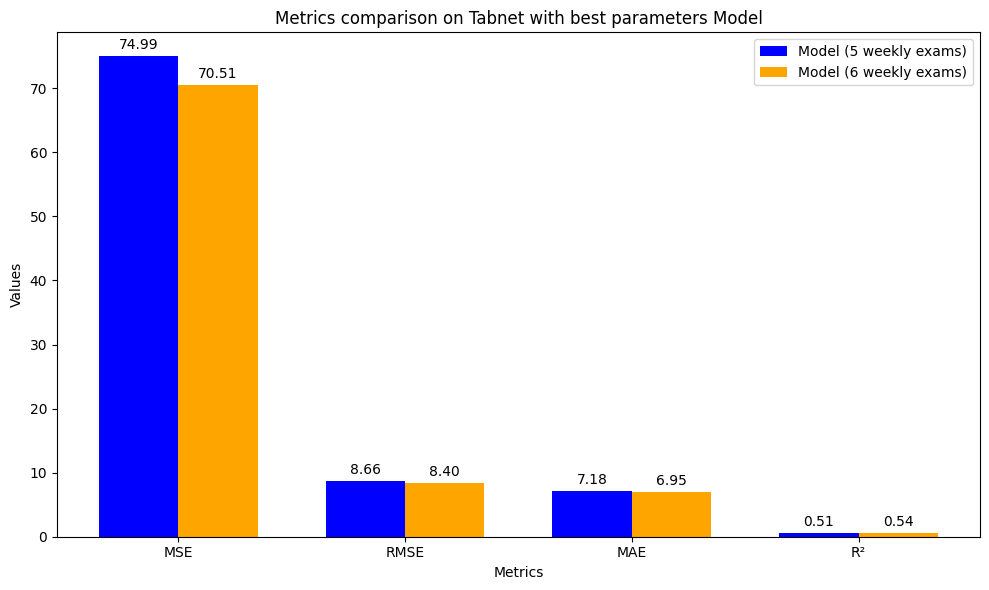

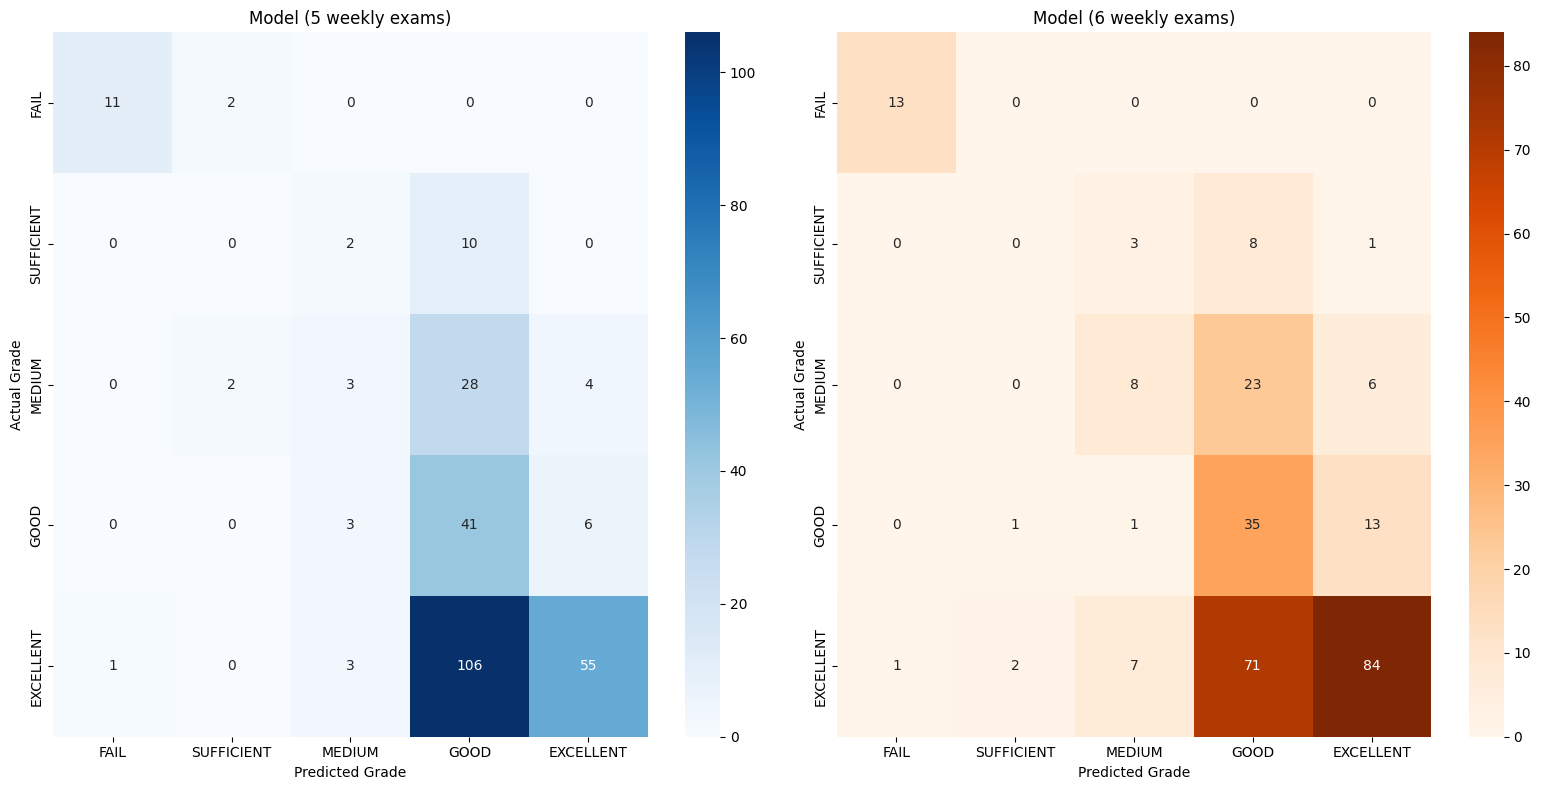

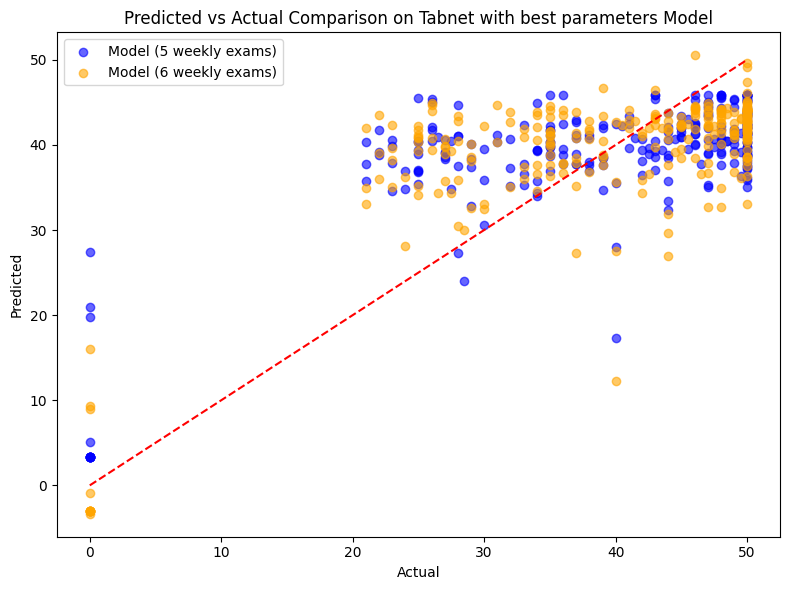

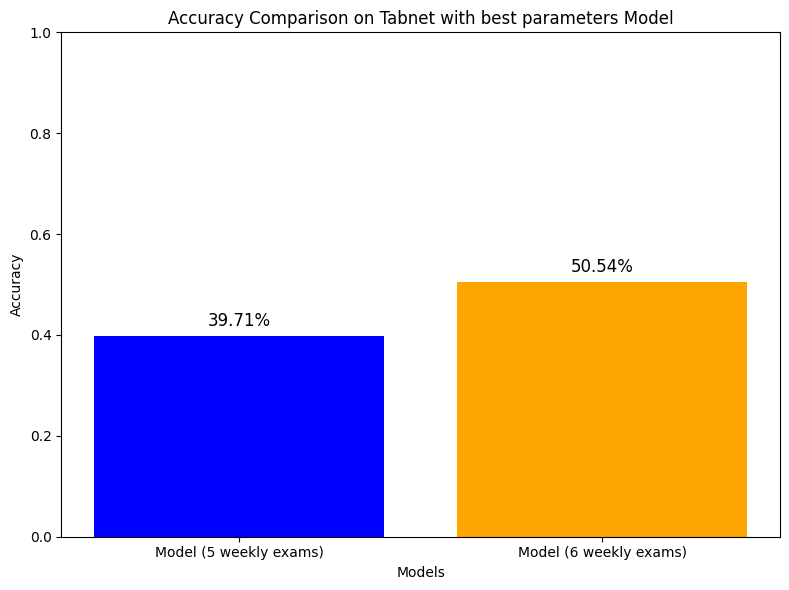

In [24]:
# Metrics calculation
tabnet_metrics_five_best = calculate_metrics(YFive_test, final_predictions_five.ravel())
tabnet_metrics_six_best = calculate_metrics(YSix_test, final_predictions_six.ravel())

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
tabnet_five_values = [tabnet_metrics_five_best["MSE"], tabnet_metrics_five_best["RMSE"], tabnet_metrics_five_best["MAE"], tabnet_metrics_five_best["R2"]]
tabnet_six_values = [tabnet_metrics_six_best["MSE"], tabnet_metrics_six_best["RMSE"], tabnet_metrics_six_best["MAE"], tabnet_metrics_six_best["R2"]]

# Plots
generate_metrics_comparison(tabnet_five_values, tabnet_six_values,"Metrics comparison on Tabnet with best parameters Model")
generate_confusion_matrices(final_predictions_five.ravel(), final_predictions_six.ravel())
generate_predicted_vs_actual_comparison(YFive_test, final_predictions_five.ravel(), YSix_test, final_predictions_six.ravel(), "Predicted vs Actual Comparison on Tabnet with best parameters Model")
generate_accuracy_comparison(tabnet_metrics_five_best["Accuracy"], tabnet_metrics_six_best["Accuracy"], "Accuracy Comparison on Tabnet with best parameters Model")

**FastAI Model**

In [12]:
data_five = pd.concat([XFive_train, YFive_train.rename("target")], axis=1)
data_six = pd.concat([XSix_train, YSix_train.rename("target")], axis=1)

dls_five = TabularDataLoaders.from_df(
    data_five, y_names="target",
    cont_names=list(XFive.columns),
    procs=[Normalize]
)

dls_six = TabularDataLoaders.from_df(
    data_six, y_names="target",
    cont_names=list(XSix.columns),
    procs=[Normalize]
)

learn_five = tabular_learner(dls_five, metrics=[mae, rmse], layers=[200, 100], n_out=1)
learn_five.fit_one_cycle(20, 1e-4)

learn_six = tabular_learner(dls_six, metrics=[mae, rmse], layers=[200, 100], n_out=1)
learn_six.fit_one_cycle(20, 1e-4)

test_preds_five, _ = learn_five.get_preds(dl=dls_five.test_dl(XFive_test))
test_preds_five = test_preds_five.numpy().flatten()
actual_test_five = YFive_test.values

test_preds_six, _ = learn_six.get_preds(dl=dls_six.test_dl(XSix_test))
test_preds_six = test_preds_six.numpy().flatten()
actual_test_six = YSix_test.values

epoch,train_loss,valid_loss,mae,_rmse,time
0,1711.726807,1757.548462,40.367867,41.923122,00:00
1,1697.651245,1755.619629,40.348721,41.900116,00:00
2,1712.728516,1752.911133,40.337791,41.867783,00:00
3,1692.835815,1745.690186,40.304173,41.781456,00:00
4,1683.305664,1735.946533,40.254692,41.664692,00:00
5,1675.748901,1726.958008,40.198151,41.556683,00:00
6,1661.956665,1725.890991,40.232590,41.543842,00:00
7,1651.513916,1712.967773,40.114986,41.388016,00:00
8,1643.384521,1706.955200,40.068817,41.315315,00:00
9,1620.236450,1694.613525,39.928730,41.165684,00:00


epoch,train_loss,valid_loss,mae,_rmse,time
0,1685.045898,1681.673950,39.141838,41.008221,00:00
1,1700.378662,1682.687744,39.164921,41.020576,00:00
2,1703.658081,1677.036621,39.132423,40.951637,00:00
3,1697.456177,1666.513794,39.073254,40.822956,00:00
4,1693.451538,1656.974487,39.029747,40.705952,00:00
5,1699.869873,1652.757935,39.038818,40.654125,00:00
6,1682.007690,1646.662231,39.013256,40.579086,00:00
7,1675.804688,1650.289429,39.105263,40.623756,00:00
8,1674.422852,1640.539307,39.002666,40.503574,00:00
9,1669.280273,1637.220703,38.983768,40.462585,00:00


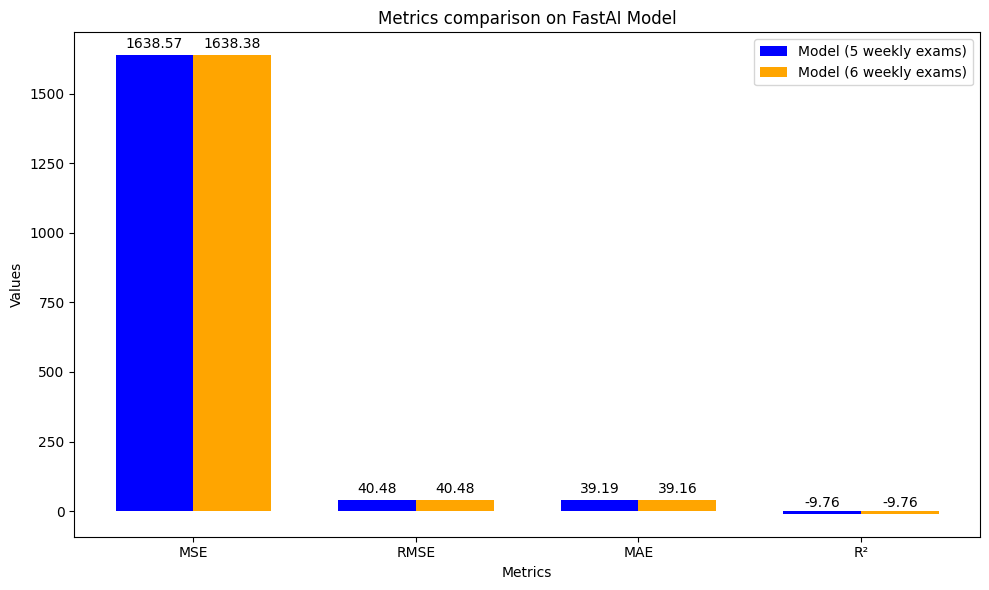

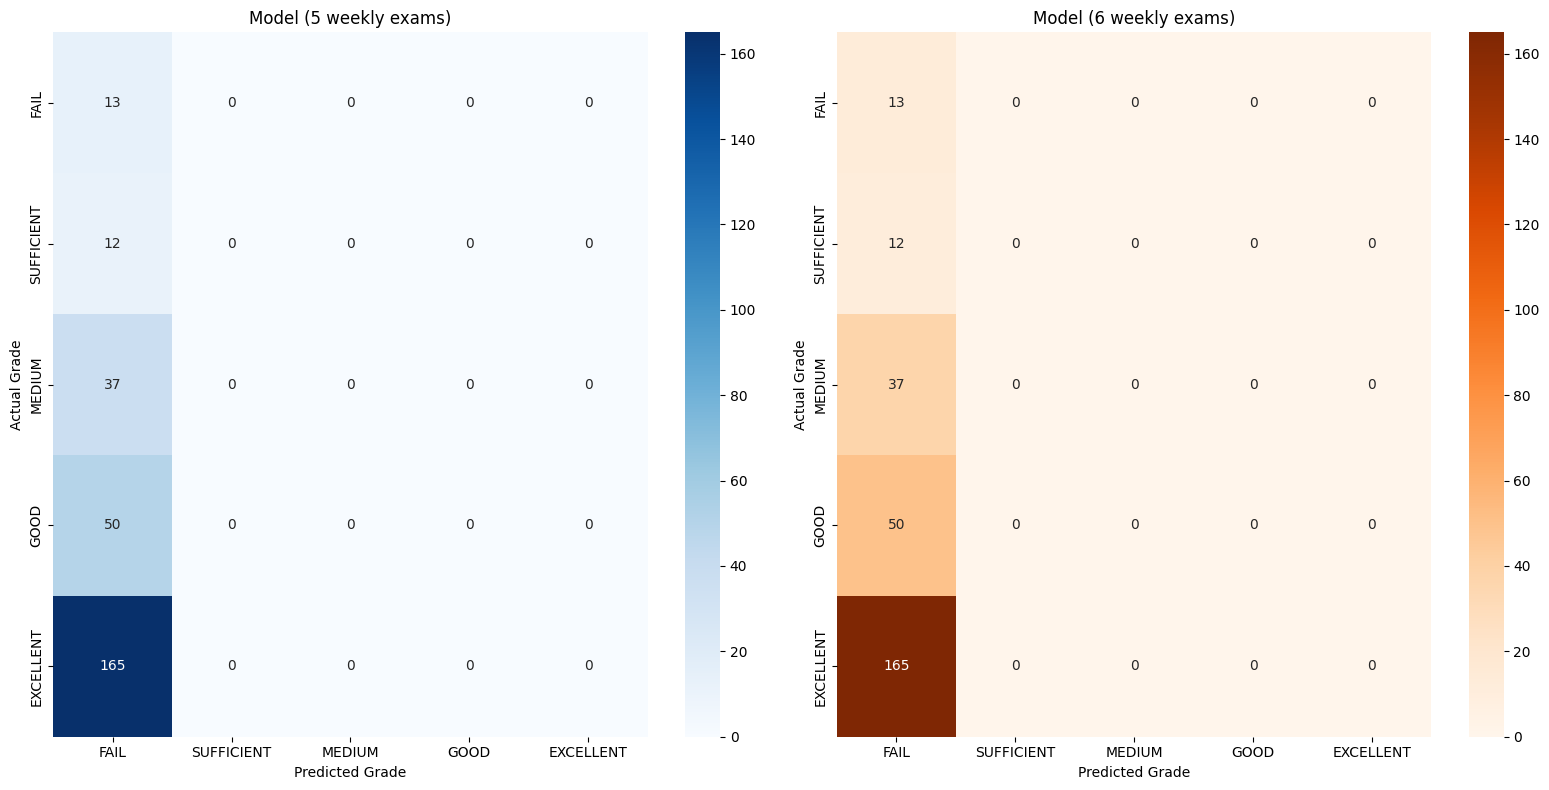

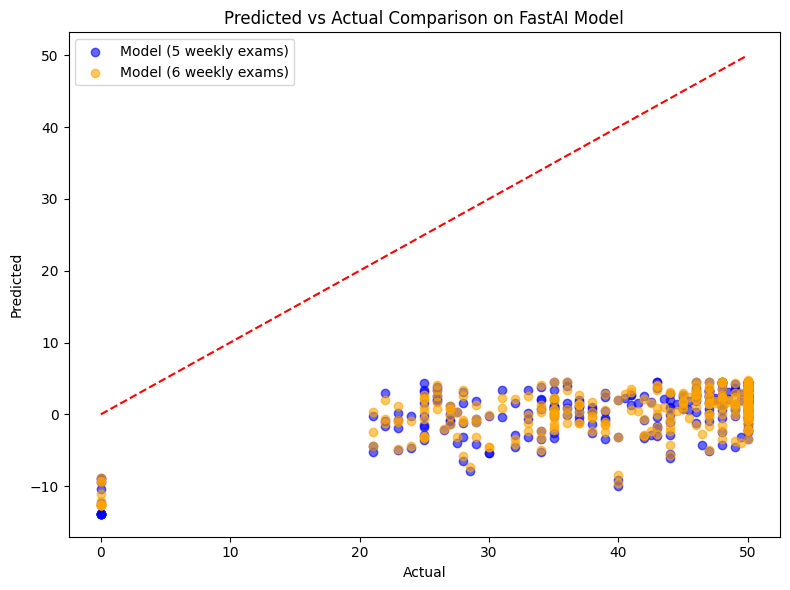

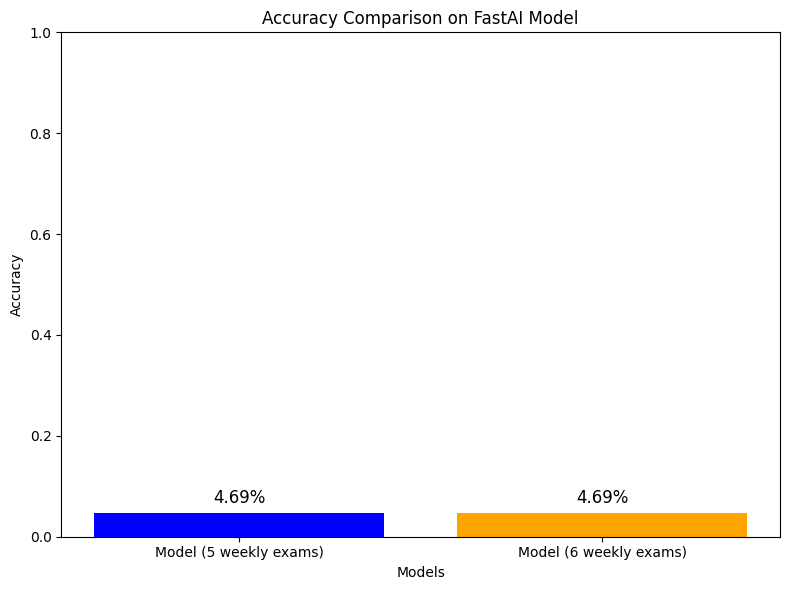

In [25]:
# Metrics calculation
fastai_metrics_five = calculate_metrics(YFive_test, test_preds_five)
fastai_metrics_six = calculate_metrics(YSix_test, test_preds_six)

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
fastai_five_values = [fastai_metrics_five["MSE"], fastai_metrics_five["RMSE"], fastai_metrics_five["MAE"], fastai_metrics_five["R2"]]
fastai_six_values = [fastai_metrics_six["MSE"], fastai_metrics_six["RMSE"], fastai_metrics_six["MAE"], fastai_metrics_six["R2"]]

# Plots
generate_metrics_comparison(fastai_five_values, fastai_six_values,"Metrics comparison on FastAI Model")
generate_confusion_matrices(test_preds_five, test_preds_six)
generate_predicted_vs_actual_comparison(YFive_test, test_preds_five, YSix_test, test_preds_six, "Predicted vs Actual Comparison on FastAI Model")
generate_accuracy_comparison(fastai_metrics_five["Accuracy"], fastai_metrics_six["Accuracy"], "Accuracy Comparison on FastAI Model")

**FastAI Model with best parameters**

In [14]:
data_five = pd.concat([XFive_train, YFive_train.rename("target")], axis=1)
data_six = pd.concat([XSix_train, YSix_train.rename("target")], axis=1)

dls_five = TabularDataLoaders.from_df(
    data_five, y_names="target",
    cont_names=list(XFive_train.columns),
    procs=[Normalize]
)

dls_six = TabularDataLoaders.from_df(
    data_six, y_names="target",
    cont_names=list(XSix_train.columns),
    procs=[Normalize]
)

def objective_five(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
    layer1 = trial.suggest_int('layer1', 100, 250)
    layer2 = trial.suggest_int('layer2', 50, 150)
    wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)

    learn = tabular_learner(
        dls_five,
        metrics=[rmse],
        layers=[layer1, layer2],
        n_out=1,
        wd=wd
    )

    learn.fit_one_cycle(10, learning_rate)
    rmse_value = float(learn.validate()[1])

    return rmse_value

def objective_six(trial):
    learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
    layer1 = trial.suggest_int('layer1', 100, 250)
    layer2 = trial.suggest_int('layer2', 50, 150)
    wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)

    learn = tabular_learner(
        dls_six,
        metrics=[rmse],
        layers=[layer1, layer2],
        n_out=1,
        wd=wd
    )

    learn.fit_one_cycle(10, learning_rate)
    rmse_value = float(learn.validate()[1])

    return rmse_value

study_five = optuna.create_study(direction='minimize')
study_five.optimize(objective_five, n_trials=20)

study_six = optuna.create_study(direction='minimize')
study_six.optimize(objective_six, n_trials=20)

best_params_five = study_five.best_params
best_params_six = study_six.best_params

print("Best Parameters for 5-Exam Model:", best_params_five)
print("Best Parameters for 6-Exam Model:", best_params_six)

learn_five = tabular_learner(
    dls_five,
    metrics=[rmse],
    layers=[best_params_five['layer1'], best_params_five['layer2']],
    n_out=1,
    wd=best_params_five['wd']
)

learn_five.fit_one_cycle(20, best_params_five['learning_rate'])

learn_six = tabular_learner(
    dls_six,
    metrics=[rmse],
    layers=[best_params_six['layer1'], best_params_six['layer2']],
    n_out=1,
    wd=best_params_six['wd']
)

learn_six.fit_one_cycle(20, best_params_six['learning_rate'])

test_preds_five_optimized, _ = learn_five.get_preds(dl=dls_five.test_dl(XFive_test))
test_preds_five_optimized = test_preds_five_optimized.numpy().flatten()
actual_test_five_optimized = YFive_test.values

test_preds_six_optimized, _ = learn_six.get_preds(dl=dls_six.test_dl(XSix_test))
test_preds_six_optimized = test_preds_six_optimized.numpy().flatten()
actual_test_six_optimized = YSix_test.values

[I 2025-03-15 15:32:11,488] A new study created in memory with name: no-name-3dd0541d-80a5-4e0f-b28d-172616236f4c
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1707.906494,1695.375000,41.174931,00:00
1,1706.880493,1663.393433,40.784718,00:00
2,1697.374390,1628.917236,40.359844,00:00
3,1676.176270,1589.366455,39.866859,00:00
4,1648.536865,1543.547974,39.288010,00:00
5,1625.601562,1526.140381,39.065845,00:00
6,1606.281128,1519.504883,38.980827,00:00
7,1587.988892,1516.254272,38.939110,00:00
8,1569.412354,1511.108765,38.872982,00:00
9,1562.026001,1522.666138,39.021355,00:00


[I 2025-03-15 15:32:12,843] Trial 0 finished with value: 39.02135467529297 and parameters: {'learning_rate': 0.0015459706949901082, 'layer1': 239, 'layer2': 60, 'wd': 0.0001}. Best is trial 0 with value: 39.02135467529297.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1687.000366,1682.975952,41.024090,00:00
1,1670.715332,1617.105835,40.213257,00:00
2,1644.060425,1552.967773,39.407711,00:00
3,1600.621948,1488.854980,38.585682,00:00
4,1561.396973,1394.468506,37.342583,00:00
5,1527.636475,1367.651733,36.981777,00:00
6,1464.697632,1312.661621,36.230671,00:00
7,1430.939819,1289.619263,35.911274,00:00
8,1382.462769,1243.912354,35.269142,00:00
9,1351.358521,1234.732788,35.138763,00:00


[I 2025-03-15 15:32:14,215] Trial 1 finished with value: 35.138763427734375 and parameters: {'learning_rate': 0.0024674653631320013, 'layer1': 129, 'layer2': 143, 'wd': 0.0001}. Best is trial 1 with value: 35.138763427734375.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1669.828003,1576.051758,39.699520,00:00
1,1504.877075,685.285217,26.177954,00:00
2,1007.325378,235.808350,15.356053,00:00
3,691.463501,137.285675,11.716897,00:00
4,501.017883,92.235725,9.603943,00:00
5,378.660187,70.683884,8.407372,00:00
6,296.805481,71.736961,8.469768,00:00
7,240.840210,71.130882,8.433913,00:00
8,198.582031,70.097511,8.372426,00:00
9,167.111954,70.052795,8.369755,00:00


[I 2025-03-15 15:32:15,627] Trial 2 finished with value: 8.369754791259766 and parameters: {'learning_rate': 0.02905268097256643, 'layer1': 182, 'layer2': 142, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1705.874146,1634.211914,40.425388,00:00
1,1605.221680,1221.557251,34.950783,00:00
2,1257.007324,151.115814,12.292917,00:00
3,851.297852,121.413803,11.018793,00:00
4,610.753479,79.136017,8.895843,00:00
5,455.941681,73.107788,8.550309,00:00
6,354.363129,71.117546,8.433122,00:00
7,281.595398,73.569756,8.577281,00:00
8,226.867386,72.662392,8.524224,00:00
9,188.900955,72.798073,8.532179,00:00


[I 2025-03-15 15:32:17,005] Trial 3 finished with value: 8.53217887878418 and parameters: {'learning_rate': 0.019657630517825535, 'layer1': 132, 'layer2': 124, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1713.457764,1664.347290,40.796410,00:00
1,1662.745483,1509.205811,38.848499,00:00
2,1565.297974,1199.645264,34.635895,00:00
3,1391.722290,707.981384,26.607920,00:00
4,1102.585693,271.300720,16.471209,00:00
5,829.859863,107.957138,10.390243,00:00
6,624.568481,72.557228,8.518053,00:00
7,479.883606,73.687553,8.584146,00:00
8,376.239777,73.183235,8.554721,00:00
9,299.564911,74.521858,8.632605,00:00


[I 2025-03-15 15:32:18,384] Trial 4 finished with value: 8.632604598999023 and parameters: {'learning_rate': 0.00812204941413197, 'layer1': 216, 'layer2': 125, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1703.157471,1666.064087,40.817451,00:00
1,1660.745850,1571.739502,39.645168,00:00
2,1594.250122,1430.738159,37.825100,00:00
3,1545.700928,1328.680786,36.451077,00:00
4,1476.963013,1224.943237,34.999187,00:00
5,1363.054321,1017.546509,31.899004,00:00
6,1244.031494,889.473694,29.824045,00:00
7,1132.252319,806.251160,28.394562,00:00
8,1033.383667,756.783386,27.509697,00:00
9,970.366028,753.670410,27.453058,00:00


[I 2025-03-15 15:32:19,778] Trial 5 finished with value: 27.45305824279785 and parameters: {'learning_rate': 0.004040320555466814, 'layer1': 211, 'layer2': 121, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1639.173950,1648.754150,40.604855,00:00
1,1613.258301,1341.956299,36.632721,00:00
2,1461.697510,826.814636,28.754383,00:00
3,1138.455444,207.853745,14.417133,00:00
4,814.177917,73.524925,8.574668,00:00
5,601.049744,82.887306,9.104246,00:00
6,457.197479,73.756287,8.588148,00:00
7,356.530975,73.227654,8.557316,00:00
8,283.872070,71.891319,8.478875,00:00
9,231.367386,72.856194,8.535583,00:00


[I 2025-03-15 15:32:21,144] Trial 6 finished with value: 8.53558349609375 and parameters: {'learning_rate': 0.016465296213009732, 'layer1': 151, 'layer2': 53, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1650.935913,1685.895020,41.059650,00:00
1,1642.189941,1647.848633,40.593700,00:00
2,1656.739258,1617.741455,40.221157,00:00
3,1635.461304,1563.703491,39.543694,00:00
4,1622.658203,1528.231689,39.092606,00:00
5,1610.696411,1539.604858,39.237801,00:00
6,1606.905884,1548.458984,39.350464,00:00
7,1597.148804,1558.789795,39.481510,00:00
8,1571.678955,1526.970459,39.076466,00:00
9,1556.271729,1528.532104,39.096447,00:00


[I 2025-03-15 15:32:22,498] Trial 7 finished with value: 39.0964469909668 and parameters: {'learning_rate': 0.0015182776456449496, 'layer1': 163, 'layer2': 67, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1624.589111,1597.469482,39.968353,00:00
1,1551.544800,944.512573,30.732924,00:00
2,1105.893799,160.480423,12.668087,00:00
3,754.931030,83.675041,9.147406,00:00
4,545.915039,77.972893,8.830226,00:00
5,406.876221,84.293785,9.181165,00:00
6,317.481445,81.019455,9.001081,00:00
7,254.842178,74.577820,8.635845,00:00
8,210.108871,72.706909,8.526834,00:00
9,175.602005,72.896904,8.537969,00:00


[I 2025-03-15 15:32:23,867] Trial 8 finished with value: 8.537968635559082 and parameters: {'learning_rate': 0.023779763361748113, 'layer1': 144, 'layer2': 131, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1692.901367,1676.662476,40.947071,00:00
1,1665.880737,1591.983154,39.899662,00:00
2,1631.763062,1497.687744,38.699974,00:00
3,1574.064331,1338.870483,36.590580,00:00
4,1496.678101,1240.933838,35.226891,00:00
5,1415.430420,1138.486328,33.741463,00:00
6,1302.294189,974.744690,31.220901,00:00
7,1191.196167,886.472473,29.773685,00:00
8,1119.819702,905.956482,30.099112,00:00
9,1060.845703,912.283447,30.204031,00:00


[I 2025-03-15 15:32:25,227] Trial 9 finished with value: 30.204030990600586 and parameters: {'learning_rate': 0.0034433259268236566, 'layer1': 183, 'layer2': 145, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1665.153076,1460.298584,38.213852,00:00
1,1392.919922,272.001923,16.492481,00:00
2,888.256287,152.889557,12.364851,00:00
3,606.610596,89.663368,9.469074,00:00
4,441.174103,72.984467,8.543095,00:00
5,336.501617,74.016815,8.603303,00:00
6,265.234894,69.285812,8.323809,00:00
7,217.041504,69.575607,8.341199,00:00
8,180.612915,71.089264,8.431445,00:00
9,153.813705,70.885719,8.419365,00:00


[I 2025-03-15 15:32:26,636] Trial 10 finished with value: 8.419364929199219 and parameters: {'learning_rate': 0.04830063724641166, 'layer1': 183, 'layer2': 90, 'wd': 0.0001}. Best is trial 2 with value: 8.369754791259766.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1635.720581,1518.486816,38.967766,00:00
1,1438.014648,533.054504,23.087975,00:00
2,918.250854,105.929794,10.292220,00:00
3,623.915344,118.147034,10.869546,00:00
4,452.828033,84.543640,9.194761,00:00
5,343.834564,69.645729,8.345402,00:00
6,272.840485,67.456337,8.213181,00:00
7,219.374863,67.671379,8.226262,00:00
8,182.623184,68.647209,8.285360,00:00
9,154.310425,68.503242,8.276669,00:00


[I 2025-03-15 15:32:28,018] Trial 11 finished with value: 8.276668548583984 and parameters: {'learning_rate': 0.04458749302891518, 'layer1': 187, 'layer2': 92, 'wd': 0.0001}. Best is trial 11 with value: 8.276668548583984.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1713.225952,1553.389771,39.413067,00:00
1,1466.945068,409.795746,20.243412,00:00
2,930.643921,220.424500,14.846700,00:00
3,636.127502,94.772133,9.735098,00:00
4,460.893005,79.995224,8.944005,00:00
5,350.586456,74.001015,8.602384,00:00
6,275.981262,69.846451,8.357419,00:00
7,223.456009,69.831841,8.356545,00:00
8,184.627533,68.468269,8.274555,00:00
9,156.712997,68.502815,8.276642,00:00


[I 2025-03-15 15:32:29,394] Trial 12 finished with value: 8.276641845703125 and parameters: {'learning_rate': 0.04493153787817174, 'layer1': 108, 'layer2': 96, 'wd': 0.0001}. Best is trial 12 with value: 8.276641845703125.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1647.863525,1553.692627,39.416908,00:00
1,1424.905396,397.803101,19.945002,00:00
2,911.603760,94.280220,9.709800,00:00
3,619.176514,85.395782,9.240984,00:00
4,450.563721,72.652786,8.523661,00:00
5,342.252106,71.671364,8.465895,00:00
6,272.397736,70.130997,8.374426,00:00
7,220.875488,67.330742,8.205531,00:00
8,184.367340,67.962875,8.243960,00:00
9,156.093658,68.343254,8.266998,00:00


[I 2025-03-15 15:32:30,778] Trial 13 finished with value: 8.266998291015625 and parameters: {'learning_rate': 0.04438481991162381, 'layer1': 101, 'layer2': 96, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1693.914551,1666.860840,40.827202,00:00
1,1673.169922,1511.604492,38.879356,00:00
2,1566.315674,1288.585815,35.896877,00:00
3,1386.501709,784.788879,28.014084,00:00
4,1125.364258,331.660004,18.211535,00:00
5,859.332520,132.291107,11.501787,00:00
6,653.937012,87.684822,9.364017,00:00
7,503.277557,77.421722,8.798961,00:00
8,394.730011,74.419746,8.626688,00:00
9,315.360291,73.859322,8.594145,00:00


[I 2025-03-15 15:32:32,171] Trial 14 finished with value: 8.594144821166992 and parameters: {'learning_rate': 0.008287880655517514, 'layer1': 101, 'layer2': 103, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1695.499023,1648.322144,40.599533,00:00
1,1634.023682,1378.746826,37.131481,00:00
2,1479.519409,921.927551,30.363260,00:00
3,1191.534668,299.880707,17.317064,00:00
4,860.973145,75.908249,8.712534,00:00
5,634.324280,93.884605,9.689406,00:00
6,480.622131,75.042580,8.662712,00:00
7,372.326630,75.632339,8.696686,00:00
8,296.095825,75.502396,8.689212,00:00
9,241.363281,74.888870,8.653835,00:00


[I 2025-03-15 15:32:33,570] Trial 15 finished with value: 8.65383529663086 and parameters: {'learning_rate': 0.012754036816683344, 'layer1': 102, 'layer2': 79, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1668.317627,1602.437500,40.030457,00:00
1,1542.072632,853.728149,29.218626,00:00
2,1048.320923,351.208099,18.740547,00:00
3,723.758179,89.484306,9.459615,00:00
4,521.793091,92.396652,9.612318,00:00
5,393.168365,73.502640,8.573368,00:00
6,307.379211,68.204979,8.258631,00:00
7,246.518295,70.440765,8.392900,00:00
8,201.419373,69.493477,8.336274,00:00
9,168.168030,69.289474,8.324030,00:00


[I 2025-03-15 15:32:34,967] Trial 16 finished with value: 8.324029922485352 and parameters: {'learning_rate': 0.02956355351574608, 'layer1': 118, 'layer2': 108, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1744.112671,1662.324463,40.771610,00:00
1,1632.454834,1373.016357,37.054237,00:00
2,1504.965576,854.415283,29.230383,00:00
3,1187.725464,243.161530,15.593638,00:00
4,852.346741,82.483849,9.082062,00:00
5,629.758972,106.208588,10.305755,00:00
6,479.652802,77.631531,8.810876,00:00
7,373.233093,75.829628,8.708021,00:00
8,296.942963,73.831413,8.592522,00:00
9,241.335953,72.758751,8.529874,00:00


[I 2025-03-15 15:32:36,355] Trial 17 finished with value: 8.529873847961426 and parameters: {'learning_rate': 0.013089955788962418, 'layer1': 113, 'layer2': 78, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1628.756836,1555.243164,39.436573,00:00
1,1486.367920,673.403564,25.950018,00:00
2,979.205383,246.389252,15.696792,00:00
3,666.566406,127.163574,11.276683,00:00
4,480.915741,71.813850,8.474305,00:00
5,364.491425,86.697151,9.311131,00:00
6,284.340088,71.831650,8.475355,00:00
7,230.417099,72.791573,8.531798,00:00
8,190.815384,72.262245,8.500721,00:00
9,161.726273,72.590065,8.519980,00:00


[I 2025-03-15 15:32:37,761] Trial 18 finished with value: 8.519980430603027 and parameters: {'learning_rate': 0.03680112313333422, 'layer1': 123, 'layer2': 110, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
<ipython-input-14-35fe01d2acc6>:17: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:20: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1656.708252,1665.693848,40.812912,00:00
1,1663.160278,1564.820435,39.557808,00:00
2,1602.111938,1329.604126,36.463737,00:00
3,1546.333130,1247.559814,35.320812,00:00
4,1440.851440,1113.782715,33.373383,00:00
5,1288.783203,844.112305,29.053612,00:00
6,1140.368652,720.433594,26.840895,00:00
7,1003.874817,621.560913,24.931124,00:00
8,885.052185,549.706482,23.445820,00:00
9,799.703369,551.667786,23.487608,00:00


[I 2025-03-15 15:32:39,147] Trial 19 finished with value: 23.487607955932617 and parameters: {'learning_rate': 0.005205597160242984, 'layer1': 143, 'layer2': 93, 'wd': 0.0001}. Best is trial 13 with value: 8.266998291015625.
[I 2025-03-15 15:32:39,148] A new study created in memory with name: no-name-8abe6f2e-003c-47d3-886e-9a8237e6f9cd
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1723.947632,1682.649414,41.020111,00:00
1,1664.924438,1641.983643,40.521400,00:00
2,1614.912842,1472.679688,38.375507,00:00
3,1526.011230,1204.484009,34.705677,00:00
4,1382.786011,956.635437,30.929523,00:00
5,1200.747192,683.860413,26.150723,00:00
6,1021.663940,514.067871,22.673065,00:00
7,859.262268,410.833191,20.269020,00:00
8,730.267639,379.670197,19.485126,00:00
9,639.507324,386.996796,19.672234,00:00


[I 2025-03-15 15:32:40,531] Trial 0 finished with value: 19.67223358154297 and parameters: {'learning_rate': 0.005077570936930275, 'layer1': 203, 'layer2': 131, 'wd': 0.0001}. Best is trial 0 with value: 19.67223358154297.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1678.775879,1691.526978,41.128178,00:00
1,1682.729004,1662.284790,40.771126,00:00
2,1650.381958,1564.760742,39.557060,00:00
3,1600.594238,1417.478516,37.649414,00:00
4,1531.866333,1371.569336,37.034702,00:00
5,1457.207275,1243.079712,35.257336,00:00
6,1385.963379,1175.740112,34.289066,00:00
7,1310.108398,1154.006226,33.970669,00:00
8,1245.497803,1095.650513,33.100613,00:00
9,1190.214478,1074.599121,32.781078,00:00


[I 2025-03-15 15:32:41,890] Trial 1 finished with value: 32.78107833862305 and parameters: {'learning_rate': 0.003589009250578471, 'layer1': 180, 'layer2': 94, 'wd': 0.0001}. Best is trial 0 with value: 19.67223358154297.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1700.078125,1685.413208,41.053787,00:00
1,1678.561523,1591.536621,39.894066,00:00
2,1592.879761,1187.650024,34.462299,00:00
3,1375.146362,670.654785,25.897005,00:00
4,1111.142700,341.486786,18.479361,00:00
5,851.349121,152.417099,12.345732,00:00
6,644.840149,107.141159,10.350902,00:00
7,494.496307,92.524048,9.618942,00:00
8,385.149078,91.209801,9.550383,00:00
9,306.896881,91.229401,9.551409,00:00


[I 2025-03-15 15:32:43,274] Trial 2 finished with value: 9.551408767700195 and parameters: {'learning_rate': 0.010078797809240234, 'layer1': 240, 'layer2': 66, 'wd': 0.0001}. Best is trial 2 with value: 9.551408767700195.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1704.733887,1677.270142,40.954491,00:00
1,1417.791504,293.289917,17.125710,00:00
2,895.464294,117.445351,10.837220,00:00
3,611.837952,103.533981,10.175165,00:00
4,444.339050,76.411621,8.741374,00:00
5,337.388153,79.888962,8.938062,00:00
6,266.631866,75.282158,8.676529,00:00
7,216.280304,76.153214,8.726581,00:00
8,176.102982,77.079308,8.779482,00:00
9,148.672745,77.397659,8.797594,00:00


[I 2025-03-15 15:32:44,667] Trial 3 finished with value: 8.79759407043457 and parameters: {'learning_rate': 0.03926600083807001, 'layer1': 159, 'layer2': 146, 'wd': 0.0001}. Best is trial 3 with value: 8.79759407043457.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1680.915649,1605.854980,40.073120,00:00
1,1572.566040,646.697815,25.430254,00:00
2,1036.967041,228.581406,15.118909,00:00
3,704.348816,110.241318,10.499587,00:00
4,511.235565,84.671265,9.201699,00:00
5,384.414368,83.611237,9.143918,00:00
6,299.385345,79.128647,8.895428,00:00
7,238.173813,74.700890,8.642967,00:00
8,195.126053,74.687447,8.642190,00:00
9,163.457413,75.215691,8.672698,00:00


[I 2025-03-15 15:32:46,044] Trial 4 finished with value: 8.672698020935059 and parameters: {'learning_rate': 0.04128541209780717, 'layer1': 109, 'layer2': 66, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1646.245850,1648.662109,40.603718,00:00
1,1559.232666,913.584106,30.225554,00:00
2,1114.433716,152.352905,12.343133,00:00
3,759.605042,102.911285,10.144520,00:00
4,544.980225,77.918121,8.827124,00:00
5,407.470032,84.075882,9.169290,00:00
6,316.182678,77.081337,8.779597,00:00
7,250.845047,79.829636,8.934743,00:00
8,205.091614,81.643486,9.035679,00:00
9,171.569733,82.432175,9.079217,00:00


[I 2025-03-15 15:32:47,409] Trial 5 finished with value: 9.079216957092285 and parameters: {'learning_rate': 0.025778194906455568, 'layer1': 174, 'layer2': 108, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1714.266968,1678.494873,40.969440,00:00
1,1699.788574,1668.725464,40.850037,00:00
2,1654.950684,1642.253662,40.524731,00:00
3,1641.544189,1616.264160,40.202789,00:00
4,1622.931885,1600.232666,40.002907,00:00
5,1625.869995,1648.126831,40.597130,00:00
6,1612.532715,1651.621338,40.640144,00:00
7,1595.548706,1618.899658,40.235550,00:00
8,1582.181763,1602.647827,40.033085,00:00
9,1566.417847,1590.296875,39.878525,00:00


[I 2025-03-15 15:32:48,829] Trial 6 finished with value: 39.87852478027344 and parameters: {'learning_rate': 0.001284458455701467, 'layer1': 199, 'layer2': 103, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1704.604980,1652.900879,40.655884,00:00
1,1609.391113,1074.019775,32.772243,00:00
2,1188.911743,211.006973,14.526078,00:00
3,805.702881,107.291245,10.358149,00:00
4,579.938538,101.764435,10.087835,00:00
5,436.020081,78.908180,8.883028,00:00
6,336.591583,80.341858,8.963362,00:00
7,267.388855,76.774109,8.762084,00:00
8,217.589462,75.830177,8.708053,00:00
9,180.717392,76.254700,8.732393,00:00


[I 2025-03-15 15:32:50,213] Trial 7 finished with value: 8.732393264770508 and parameters: {'learning_rate': 0.02697928390497296, 'layer1': 148, 'layer2': 76, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1662.265869,1544.481567,39.299892,00:00
1,1361.629272,211.159164,14.531317,00:00
2,862.416748,96.294472,9.812974,00:00
3,593.951416,100.183128,10.009152,00:00
4,433.637085,86.347244,9.292322,00:00
5,329.478607,84.998001,9.219437,00:00
6,259.605591,83.013718,9.111186,00:00
7,209.150391,81.077980,9.004331,00:00
8,173.387726,81.849510,9.047071,00:00
9,147.258789,79.441803,8.913013,00:00


[I 2025-03-15 15:32:51,614] Trial 8 finished with value: 8.913013458251953 and parameters: {'learning_rate': 0.04475063507132404, 'layer1': 220, 'layer2': 125, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1692.572510,1673.514404,40.908607,00:00
1,1619.981689,1535.439941,39.184692,00:00
2,1524.814331,1057.407837,32.517811,00:00
3,1316.040283,621.170471,24.923292,00:00
4,1019.179016,224.287033,14.976215,00:00
5,756.167480,98.879562,9.943820,00:00
6,570.561523,94.798653,9.736461,00:00
7,438.864960,87.528610,9.355673,00:00
8,343.075928,86.922401,9.323218,00:00
9,274.531036,86.248894,9.287028,00:00


[I 2025-03-15 15:32:52,971] Trial 9 finished with value: 9.287028312683105 and parameters: {'learning_rate': 0.008804844822762828, 'layer1': 131, 'layer2': 120, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1655.922852,1658.722778,40.727421,00:00
1,1636.150391,1475.656860,38.414276,00:00
2,1502.185303,972.792664,31.189625,00:00
3,1205.836914,311.059082,17.636868,00:00
4,876.805237,93.335564,9.661034,00:00
5,644.311340,90.802719,9.529046,00:00
6,489.886017,82.763817,9.097462,00:00
7,381.197174,81.591049,9.032777,00:00
8,301.852173,80.208488,8.955919,00:00
9,242.874908,81.146225,9.008120,00:00


[I 2025-03-15 15:32:54,354] Trial 10 finished with value: 9.008119583129883 and parameters: {'learning_rate': 0.0155497504677718, 'layer1': 100, 'layer2': 50, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1653.046631,1653.013306,40.657265,00:00
1,1613.917358,1515.005859,38.923073,00:00
2,1301.302734,267.038361,16.341309,00:00
3,888.686340,162.738403,12.756896,00:00
4,637.260986,82.526741,9.084423,00:00
5,473.254730,77.398544,8.797644,00:00
6,364.046631,79.084274,8.892934,00:00
7,287.527435,80.306282,8.961377,00:00
8,231.934479,78.527252,8.861561,00:00
9,191.961884,78.533630,8.861919,00:00


[I 2025-03-15 15:32:55,753] Trial 11 finished with value: 8.861919403076172 and parameters: {'learning_rate': 0.021093686469062945, 'layer1': 125, 'layer2': 77, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1684.838379,1609.857788,40.123032,00:00
1,1456.231689,396.989960,19.924606,00:00
2,924.746277,141.273483,11.885852,00:00
3,625.305420,90.806129,9.529225,00:00
4,450.661743,74.835243,8.650736,00:00
5,344.182404,78.697601,8.871167,00:00
6,271.155060,77.427132,8.799269,00:00
7,218.257370,78.361443,8.852200,00:00
8,180.273697,77.706726,8.815142,00:00
9,153.324478,78.133347,8.839307,00:00


[I 2025-03-15 15:32:57,149] Trial 12 finished with value: 8.839306831359863 and parameters: {'learning_rate': 0.047154167264893604, 'layer1': 137, 'layer2': 79, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1679.734863,1662.602539,40.775024,00:00
1,1666.031738,1533.406006,39.158730,00:00
2,1490.482788,651.747498,25.529346,00:00
3,1126.088379,141.088425,11.878065,00:00
4,799.362366,85.868416,9.266521,00:00
5,591.972351,80.481125,8.971128,00:00
6,450.112610,84.959160,9.217329,00:00
7,350.371155,80.821854,8.990097,00:00
8,279.105194,79.406845,8.911052,00:00
9,226.767105,79.480957,8.915210,00:00


[I 2025-03-15 15:32:58,547] Trial 13 finished with value: 8.915209770202637 and parameters: {'learning_rate': 0.017661000427463117, 'layer1': 102, 'layer2': 50, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1670.574707,1639.810791,40.494579,00:00
1,1562.599243,962.164978,31.018784,00:00
2,1151.884155,142.032837,11.917753,00:00
3,780.971069,115.561462,10.749951,00:00
4,563.169189,89.715134,9.471807,00:00
5,421.182373,82.535988,9.084932,00:00
6,325.560455,76.874359,8.767802,00:00
7,258.392181,76.171432,8.727624,00:00
8,208.671524,77.737671,8.816896,00:00
9,174.291611,77.783516,8.819497,00:00


[I 2025-03-15 15:32:59,970] Trial 14 finished with value: 8.819497108459473 and parameters: {'learning_rate': 0.027572064259785718, 'layer1': 150, 'layer2': 73, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1710.401123,1686.762451,41.070213,00:00
1,1692.196777,1667.244263,40.831902,00:00
2,1660.037720,1625.291626,40.314903,00:00
3,1648.980713,1588.780273,39.859505,00:00
4,1611.561401,1584.787354,39.809387,00:00
5,1592.599365,1574.732544,39.682899,00:00
6,1564.875854,1533.269287,39.156982,00:00
7,1546.726074,1541.842163,39.266296,00:00
8,1521.345093,1510.948853,38.870926,00:00
9,1498.972046,1502.686279,38.764496,00:00


[I 2025-03-15 15:33:01,400] Trial 15 finished with value: 38.764495849609375 and parameters: {'learning_rate': 0.0021041913823115575, 'layer1': 117, 'layer2': 92, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1664.234863,1670.531494,40.872139,00:00
1,1625.772705,1493.467041,38.645401,00:00
2,1538.971802,1061.036011,32.573547,00:00
3,1315.490234,551.371765,23.481306,00:00
4,1020.054810,191.563354,13.840641,00:00
5,760.560974,98.160881,9.907619,00:00
6,572.260803,100.559525,10.027937,00:00
7,439.158661,82.793434,9.099090,00:00
8,346.375092,83.273163,9.125413,00:00
9,275.631012,80.274467,8.959602,00:00


[I 2025-03-15 15:33:03,052] Trial 16 finished with value: 8.959602355957031 and parameters: {'learning_rate': 0.011609984221576912, 'layer1': 154, 'layer2': 62, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1655.651489,1614.266724,40.177937,00:00
1,1536.070190,957.423645,30.942263,00:00
2,1063.787720,216.029053,14.697927,00:00
3,724.906799,139.567810,11.813882,00:00
4,522.619568,88.567261,9.411019,00:00
5,392.813416,82.041451,9.057673,00:00
6,304.442413,81.962135,9.053294,00:00
7,243.665649,77.764160,8.818399,00:00
8,201.493134,78.008118,8.832221,00:00
9,168.444092,78.909973,8.883129,00:00


[I 2025-03-15 15:33:04,465] Trial 17 finished with value: 8.883129119873047 and parameters: {'learning_rate': 0.03114144749501464, 'layer1': 115, 'layer2': 82, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1691.317627,1679.031250,40.975983,00:00
1,1649.340454,1638.998901,40.484554,00:00
2,1606.580078,1440.357422,37.952038,00:00
3,1566.651489,1414.739502,37.613022,00:00
4,1489.284302,1293.014404,35.958508,00:00
5,1386.657593,1125.088989,33.542347,00:00
6,1293.408203,1017.368225,31.896210,00:00
7,1210.842407,969.079834,31.130047,00:00
8,1130.234985,921.428711,30.355043,00:00
9,1067.115967,915.285583,30.253687,00:00


[I 2025-03-15 15:33:05,886] Trial 18 finished with value: 30.253686904907227 and parameters: {'learning_rate': 0.004989221635460618, 'layer1': 142, 'layer2': 61, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.
<ipython-input-14-35fe01d2acc6>:36: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('learning_rate', 1e-3, 5e-2)
<ipython-input-14-35fe01d2acc6>:39: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  wd = trial.suggest_loguniform('wd', 1e-4, 1e-4)


epoch,train_loss,valid_loss,_rmse,time
0,1672.207275,1655.856445,40.692215,00:00
1,1602.133545,1459.137695,38.198662,00:00
2,1399.285400,687.197754,26.214457,00:00
3,1014.759094,117.167877,10.824410,00:00
4,725.038208,91.234665,9.551684,00:00
5,536.688782,81.526428,9.029199,00:00
6,408.905029,78.913193,8.883309,00:00
7,321.631378,78.856346,8.880110,00:00
8,257.198578,77.902435,8.826236,00:00
9,209.874039,77.704430,8.815012,00:00


[I 2025-03-15 15:33:07,303] Trial 19 finished with value: 8.815011978149414 and parameters: {'learning_rate': 0.01583638185547468, 'layer1': 171, 'layer2': 88, 'wd': 0.0001}. Best is trial 4 with value: 8.672698020935059.


Best Parameters for 5-Exam Model: {'learning_rate': 0.04438481991162381, 'layer1': 101, 'layer2': 96, 'wd': 0.0001}
Best Parameters for 6-Exam Model: {'learning_rate': 0.04128541209780717, 'layer1': 109, 'layer2': 66, 'wd': 0.0001}


epoch,train_loss,valid_loss,_rmse,time
0,1634.151245,1622.925903,40.285553,00:00
1,1611.092773,1319.542236,36.325504,00:00
2,1355.864136,289.743713,17.021860,00:00
3,940.622192,122.155174,11.052383,00:00
4,677.089966,78.168846,8.841314,00:00
5,504.319000,75.002441,8.660395,00:00
6,389.182709,68.094032,8.251910,00:00
7,308.134216,82.294693,9.071642,00:00
8,250.643280,73.235092,8.557751,00:00
9,207.332809,74.646439,8.639817,00:00


epoch,train_loss,valid_loss,_rmse,time
0,1677.770020,1646.598267,40.578297,00:00
1,1639.797729,1482.785034,38.506947,00:00
2,1445.687012,458.592163,21.414764,00:00
3,1032.958862,431.279877,20.767277,00:00
4,747.147217,138.507965,11.768941,00:00
5,555.363708,81.173737,9.009646,00:00
6,423.023468,89.618996,9.466731,00:00
7,331.888428,91.888161,9.585832,00:00
8,266.143188,88.165421,9.389645,00:00
9,217.664581,80.954277,8.997459,00:00


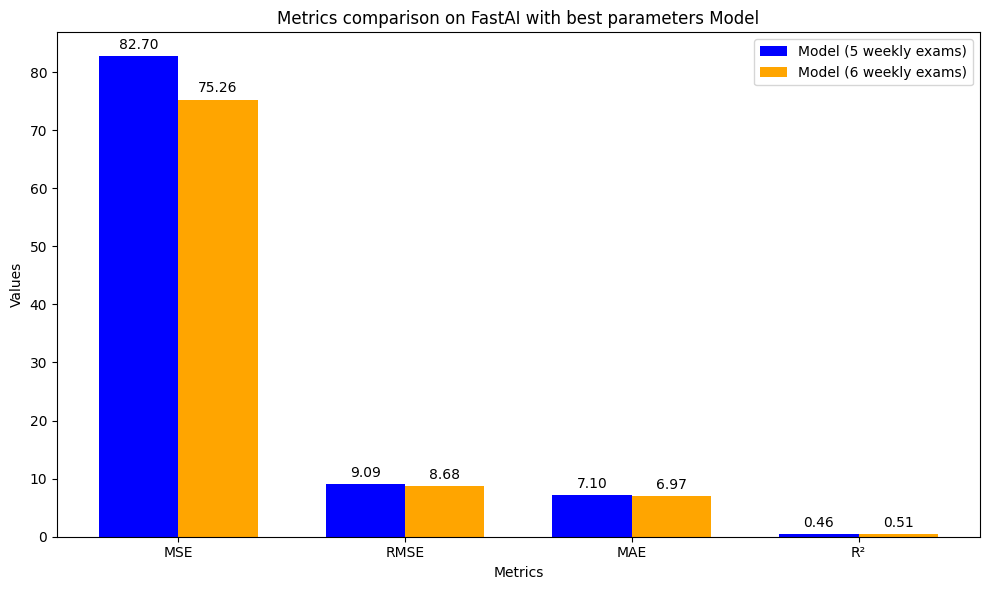

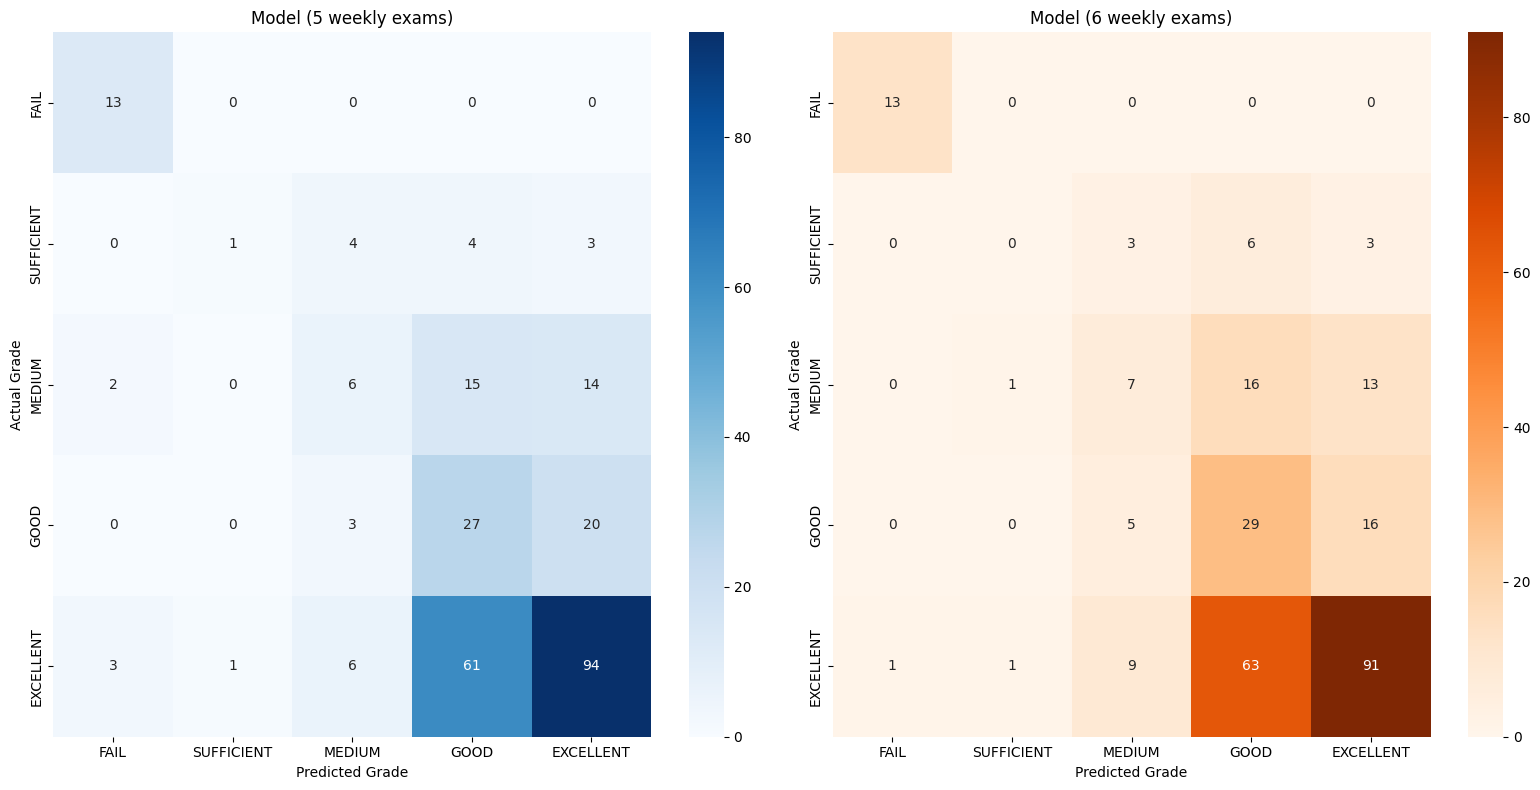

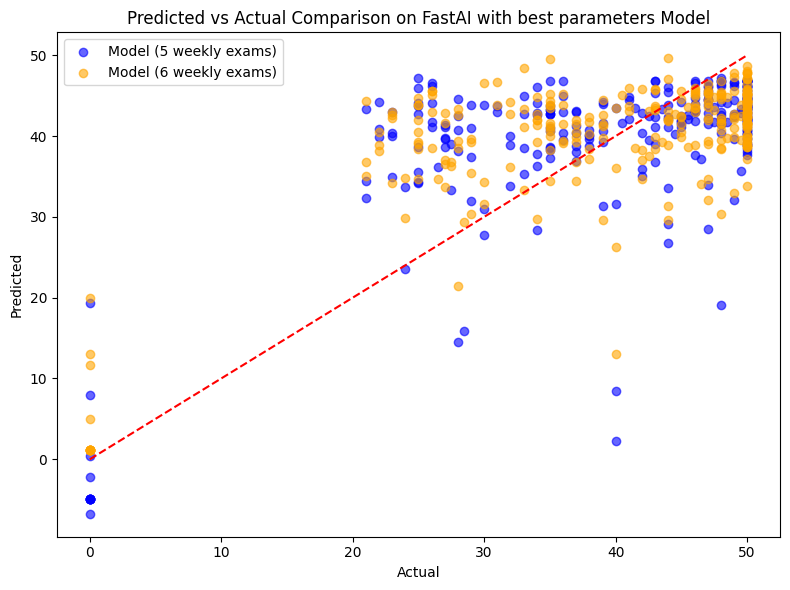

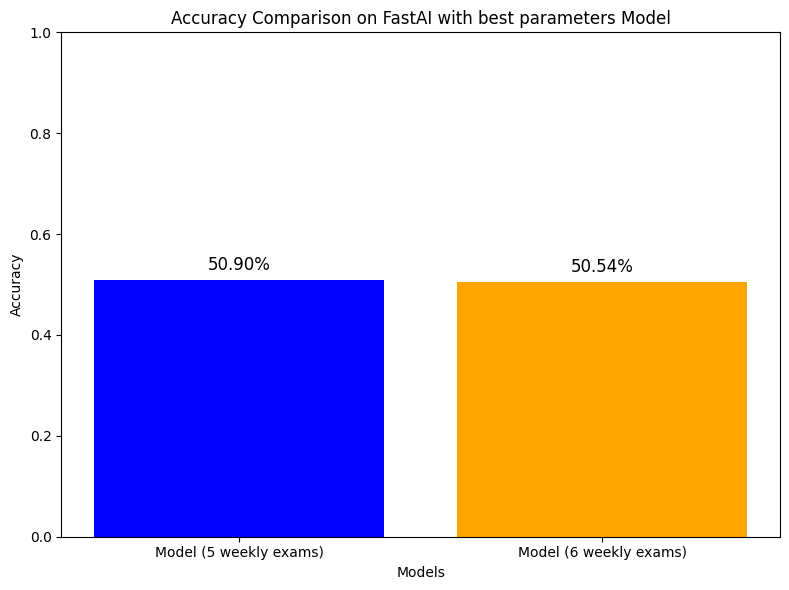

In [26]:
# Metrics calculation
fastai_metrics_five_best = calculate_metrics(YFive_test, test_preds_five_optimized)
fastai_metrics_six_best = calculate_metrics(YSix_test, test_preds_six_optimized)

metrics = ['MSE', 'RMSE', 'MAE', 'R²']

# Values for each model
fastai_best_five_values = [fastai_metrics_five_best["MSE"], fastai_metrics_five_best["RMSE"], fastai_metrics_five_best["MAE"], fastai_metrics_five_best["R2"]]
fastai_best_six_values = [fastai_metrics_six_best["MSE"], fastai_metrics_six_best["RMSE"], fastai_metrics_six_best["MAE"], fastai_metrics_six_best["R2"]]

# Plots
generate_metrics_comparison(fastai_best_five_values, fastai_best_six_values,"Metrics comparison on FastAI with best parameters Model")
generate_confusion_matrices(test_preds_five_optimized, test_preds_six_optimized)
generate_predicted_vs_actual_comparison(YFive_test, test_preds_five_optimized, YSix_test, test_preds_six_optimized, "Predicted vs Actual Comparison on FastAI with best parameters Model")
generate_accuracy_comparison(fastai_metrics_five_best["Accuracy"], fastai_metrics_six_best["Accuracy"], "Accuracy Comparison on FastAI with best parameters Model")

**Comparison**

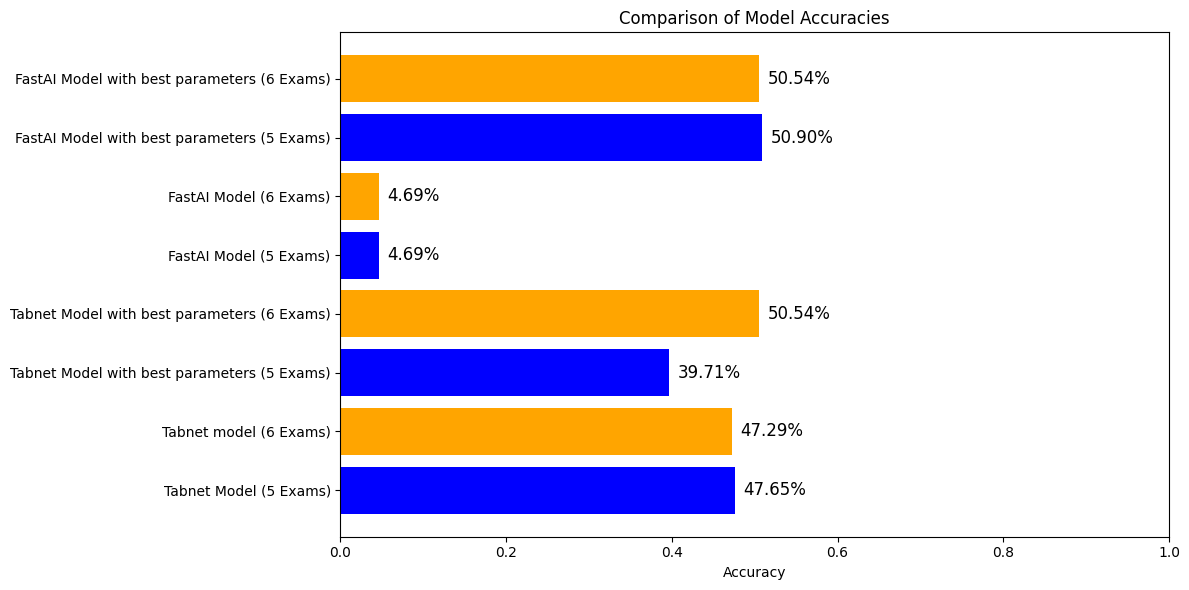

In [27]:
models = [
    "Tabnet Model (5 Exams)", "Tabnet model (6 Exams)",
    "Tabnet Model with best parameters (5 Exams)", "Tabnet Model with best parameters (6 Exams)",
    "FastAI Model (5 Exams)", "FastAI Model (6 Exams)",
    "FastAI Model with best parameters (5 Exams)", "FastAI Model with best parameters (6 Exams)",
]

accuracies = [
    tabnet_metrics_five["Accuracy"], tabnet_metrics_six["Accuracy"],
    tabnet_metrics_five_best["Accuracy"], tabnet_metrics_six_best["Accuracy"],
    fastai_metrics_five["Accuracy"], fastai_metrics_six["Accuracy"],
    fastai_metrics_five_best["Accuracy"], fastai_metrics_six_best["Accuracy"]
]

# Plot comparison of all SVM-based model accuracies
plt.figure(figsize=(12, 6))
plt.barh(models, accuracies, color=['blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange', 'blue', 'orange'])
plt.xlabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xlim(0, 1)  # Accuracy ranges from 0 to 1

# Annotate each bar with accuracy values
for i, acc in enumerate(accuracies):
    plt.text(acc + 0.01, i, f"{acc:.2%}", ha='left', va='center', fontsize=12, color='black')

plt.tight_layout()
plt.show()